In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import RandomizedSearchCV

# dont run data preparation block

In [78]:
df = pd.read_csv("PJME_hourly.csv")
df["Datetime"] = pd.to_datetime(df["Datetime"])
df["year"] =  pd.DatetimeIndex(df['Datetime']).year
df3 = df[df["year"] == 2003]
df4 = df[df["year"] == 2004]
df5 = df[df["year"] == 2005]
df6 = df[df["year"] == 2006]
data = pd.concat([df3,df4,df5,df6], axis = 0)
data.to_csv("PJME_2019_2020_2021_2022.csv",index = False)

# actual project starts here

In [2]:
df = pd.read_csv("upload_data.csv")
df.head()

,Datetime,temp
0,1/1/2019 0:00,55.68
1,12/31/2019 1:00,52.83
2,12/31/2019 2:00,51.63
3,12/31/2019 3:00,51.24
4,12/31/2019 4:00,52.23


In [3]:
df["temp"].max()

119.8

In [4]:
df["temp"].min()

0.1

In [5]:
df.shape

(35056, 2)

In [6]:
df = df.set_index("Datetime")
df.index = pd.to_datetime(df.index)
df.head()

,temp
Datetime,
2019-01-01 00:00:00,55.68
2019-12-31 01:00:00,52.83
2019-12-31 02:00:00,51.63
2019-12-31 03:00:00,51.24
2019-12-31 04:00:00,52.23


In [7]:
df[df["temp"]==0.1].shape

(411, 1)

In [8]:
# df["Datetime"] = pd.to_datetime(df["Datetime"])
# df["year"] =  pd.DatetimeIndex(df['Datetime']).year
# df["year"].value_counts()

In [9]:
df[df["temp"]==0.1].tail(15)

,temp
Datetime,
2022-07-27 05:00:00,0.1
2022-07-27 06:00:00,0.1
2022-07-27 07:00:00,0.1
2022-07-27 08:00:00,0.1
2022-07-27 09:00:00,0.1
2022-07-27 10:00:00,0.1
2022-07-27 11:00:00,0.1
2022-07-27 12:00:00,0.1
2022-07-27 13:00:00,0.1


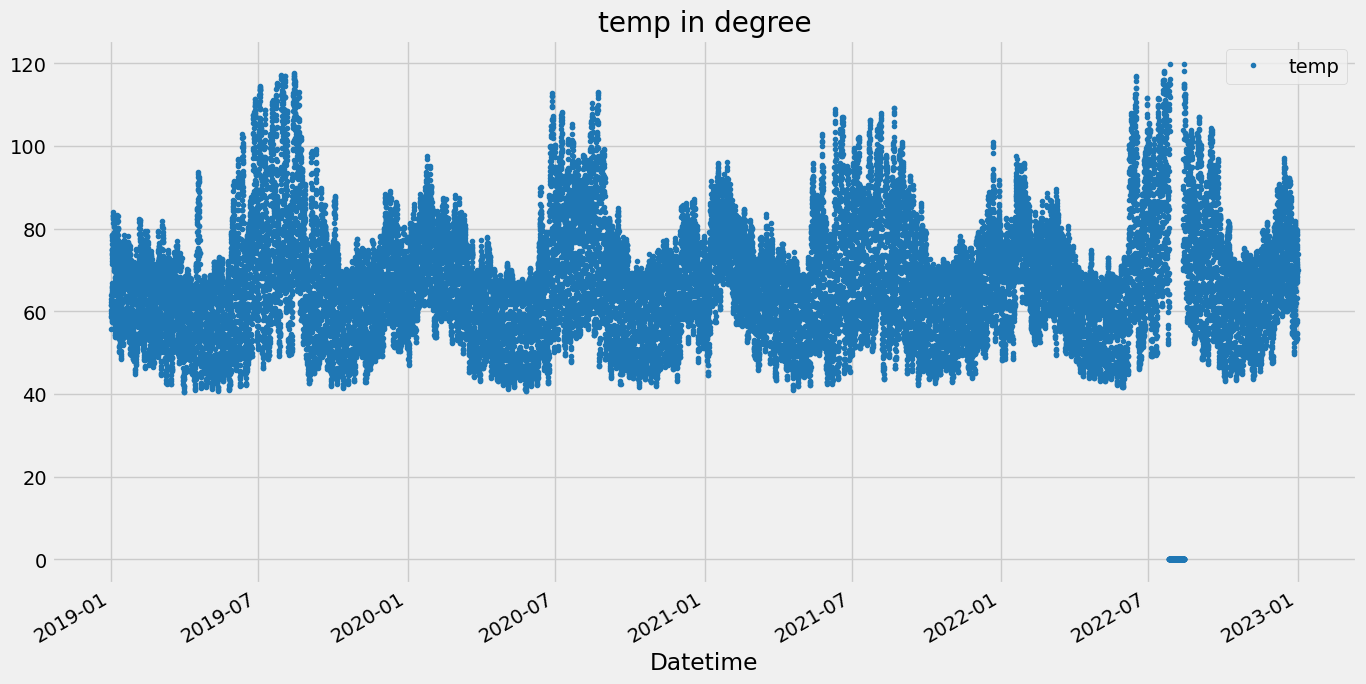

In [10]:
df.plot(style = '.',
        color = color_pal[0],
        figsize = (15,8),
        title = 'temp in degree'
)
plt.show()

# Outlier Analysis and removal

<Axes: ylabel='Frequency'>

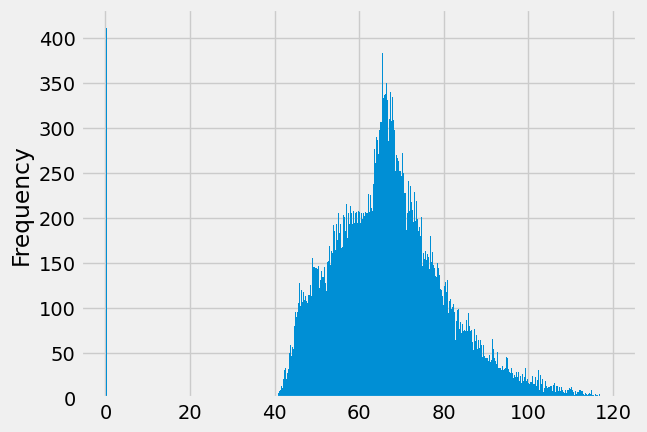

In [11]:
df["temp"].plot(kind = "hist",bins = 500)

In [12]:
Q1 = np.percentile(df["temp"], 25)
Q3 = np.percentile(df["temp"], 75)

# Calculate interquartile range (IQR)
IQR = Q3 - Q1

# Identify potential outliers (values below Q1 - 1.5 IQR or above Q3 + 1.5 IQR)
lower_bound = Q1 - (1.5 * IQR)

outliers = [x for x in df["temp"] if x < lower_bound]
len(outliers)

411

<Axes: xlabel='Datetime'>

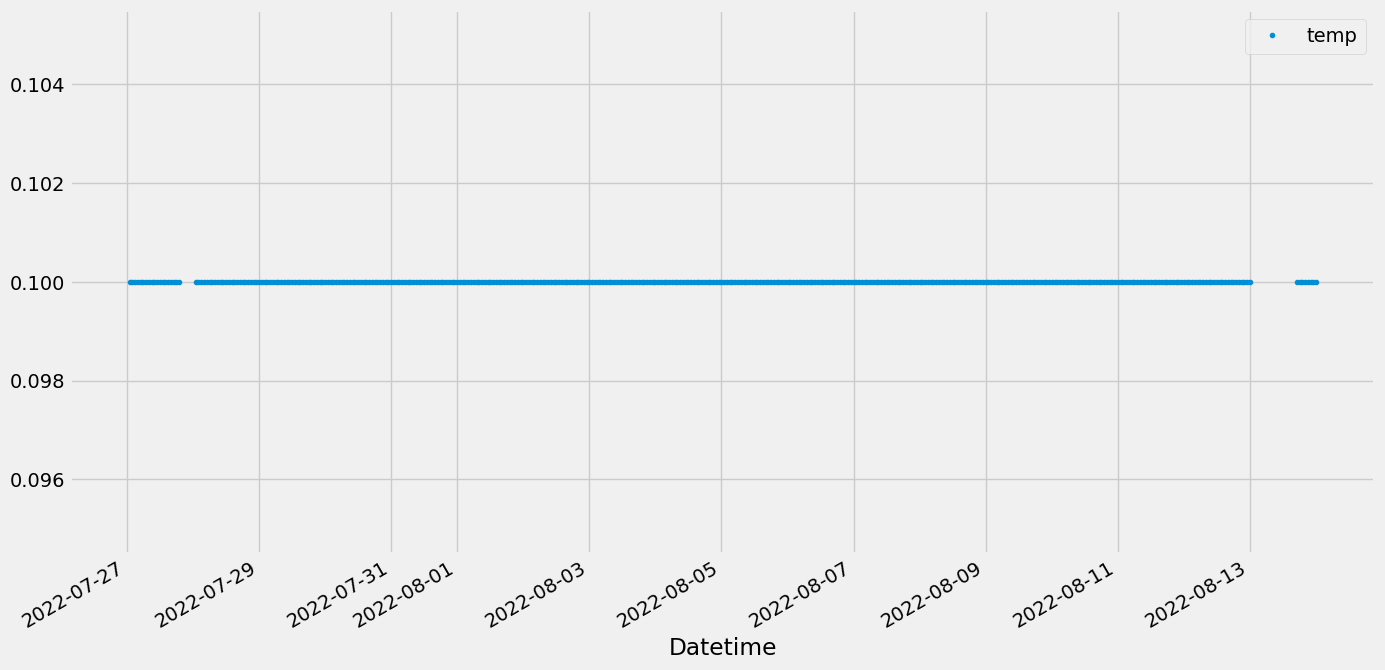

In [13]:
df.query('temp < 20').plot(figsize=(15,8), style = ".")

<Axes: xlabel='Datetime'>

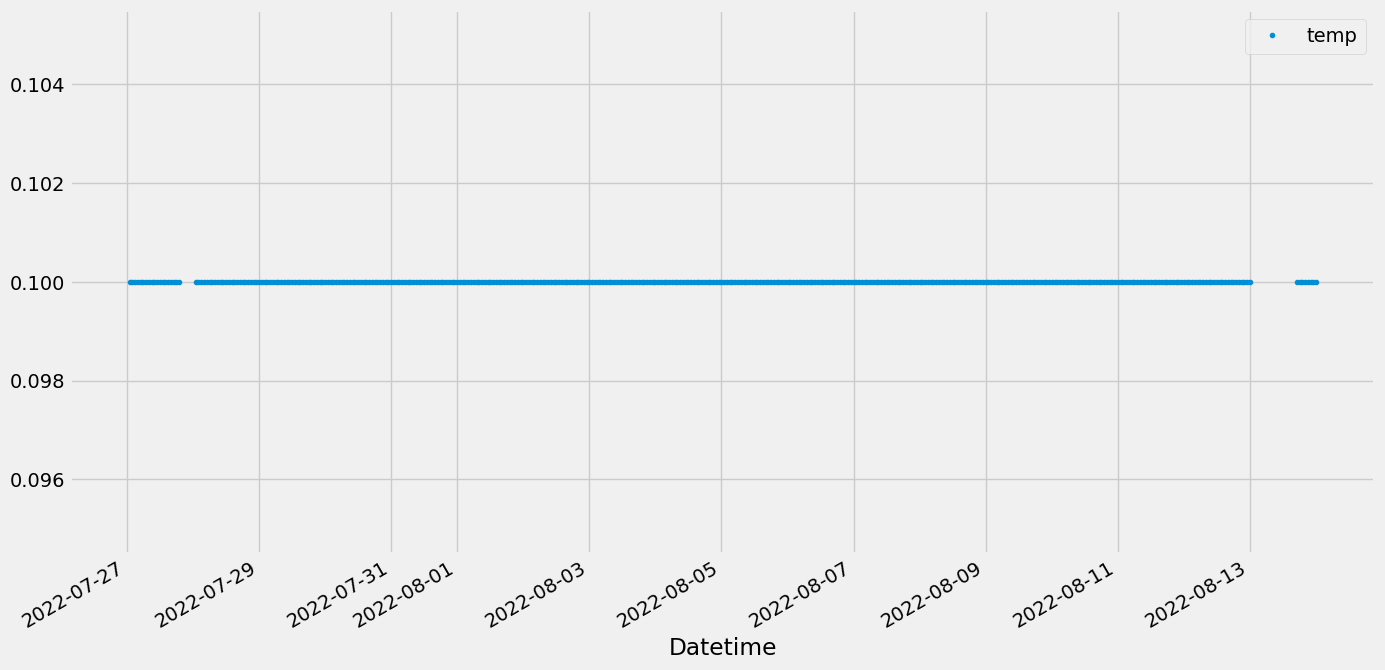

In [14]:
df.query('temp < 10').plot(figsize=(15,8), style = ".")

In [15]:
df1 = df.query('temp > 20').copy()

In [16]:
df1.head()

,temp
Datetime,
2019-01-01 00:00:00,55.68
2019-12-31 01:00:00,52.83
2019-12-31 02:00:00,51.63
2019-12-31 03:00:00,51.24
2019-12-31 04:00:00,52.23


# dont need to run these blocks

In [17]:
df1.index < '01-01-2015'

array([False, False, False, ..., False, False, False])

In [18]:
train = df1.iloc[df1.index < '01-01-2015']
test = df1.iloc[df1.index >= '01-01-2015']

<Axes: title={'center': 'Data train/test split'}, xlabel='Datetime'>

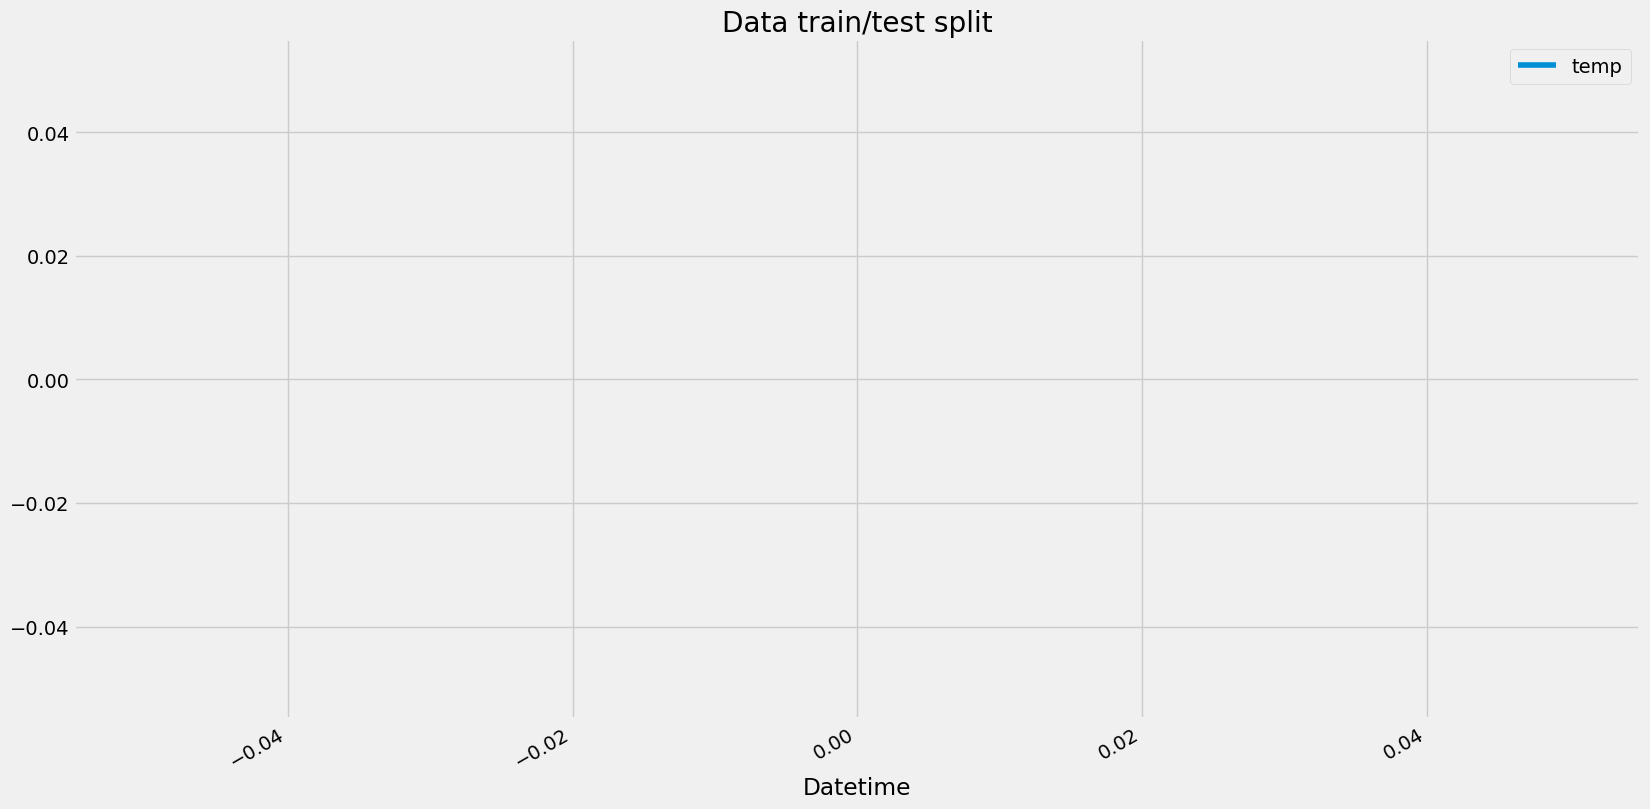

In [19]:
fig, ax = plt.subplots(figsize = (18,10))
train.plot(ax = ax, label = "train data", title= "Data train/test split")

<Axes: title={'center': 'Data train/test split'}, xlabel='Datetime'>

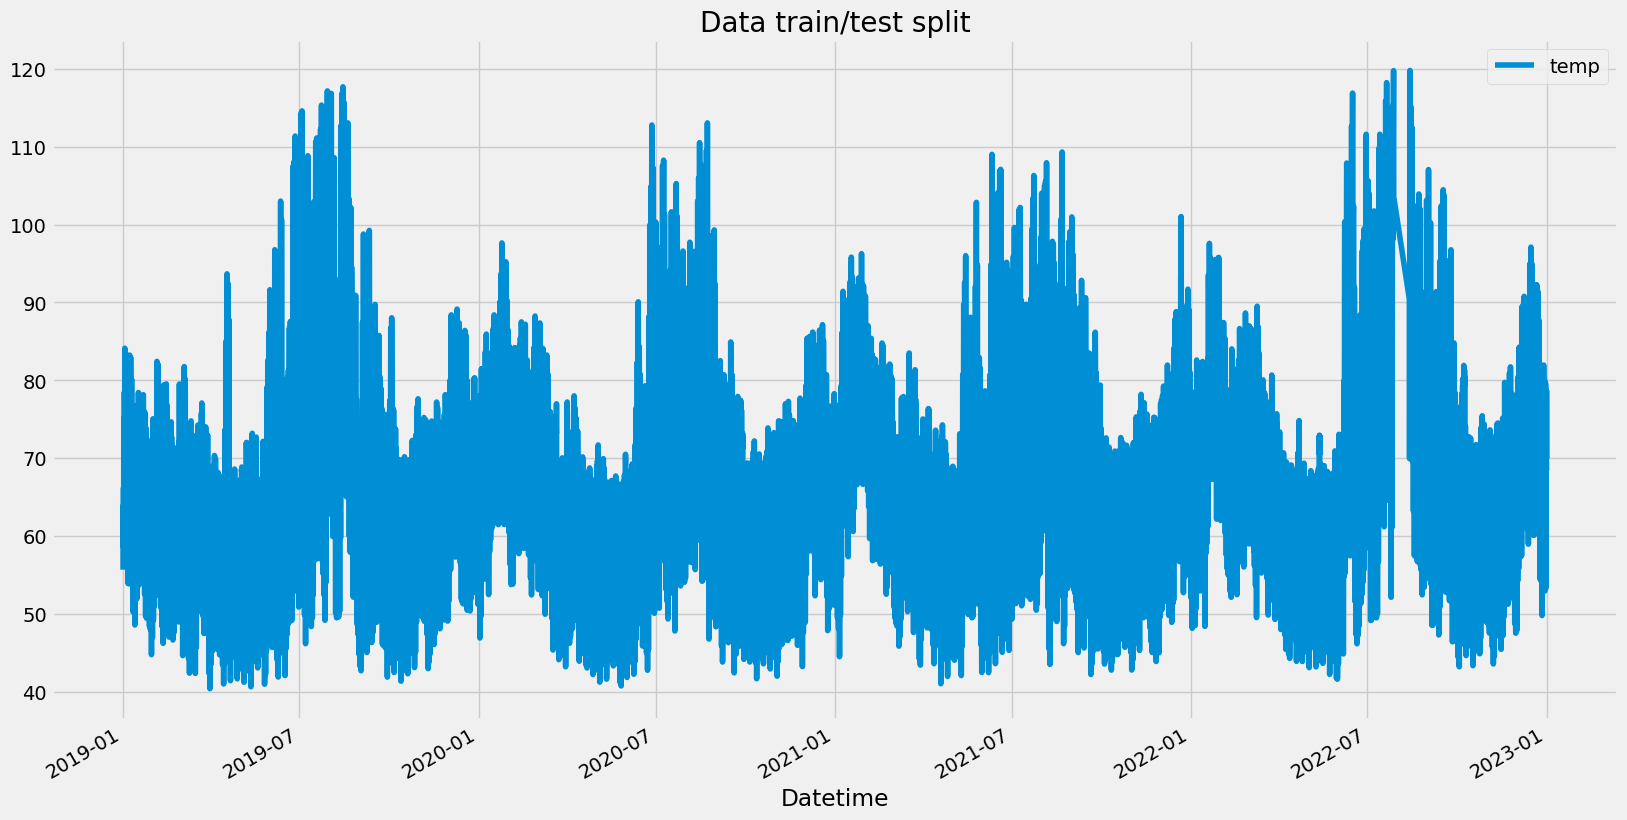

In [20]:
fig, ax = plt.subplots(figsize = (18,10))
test.plot(ax = ax, label = "test data", title= "Data train/test split")

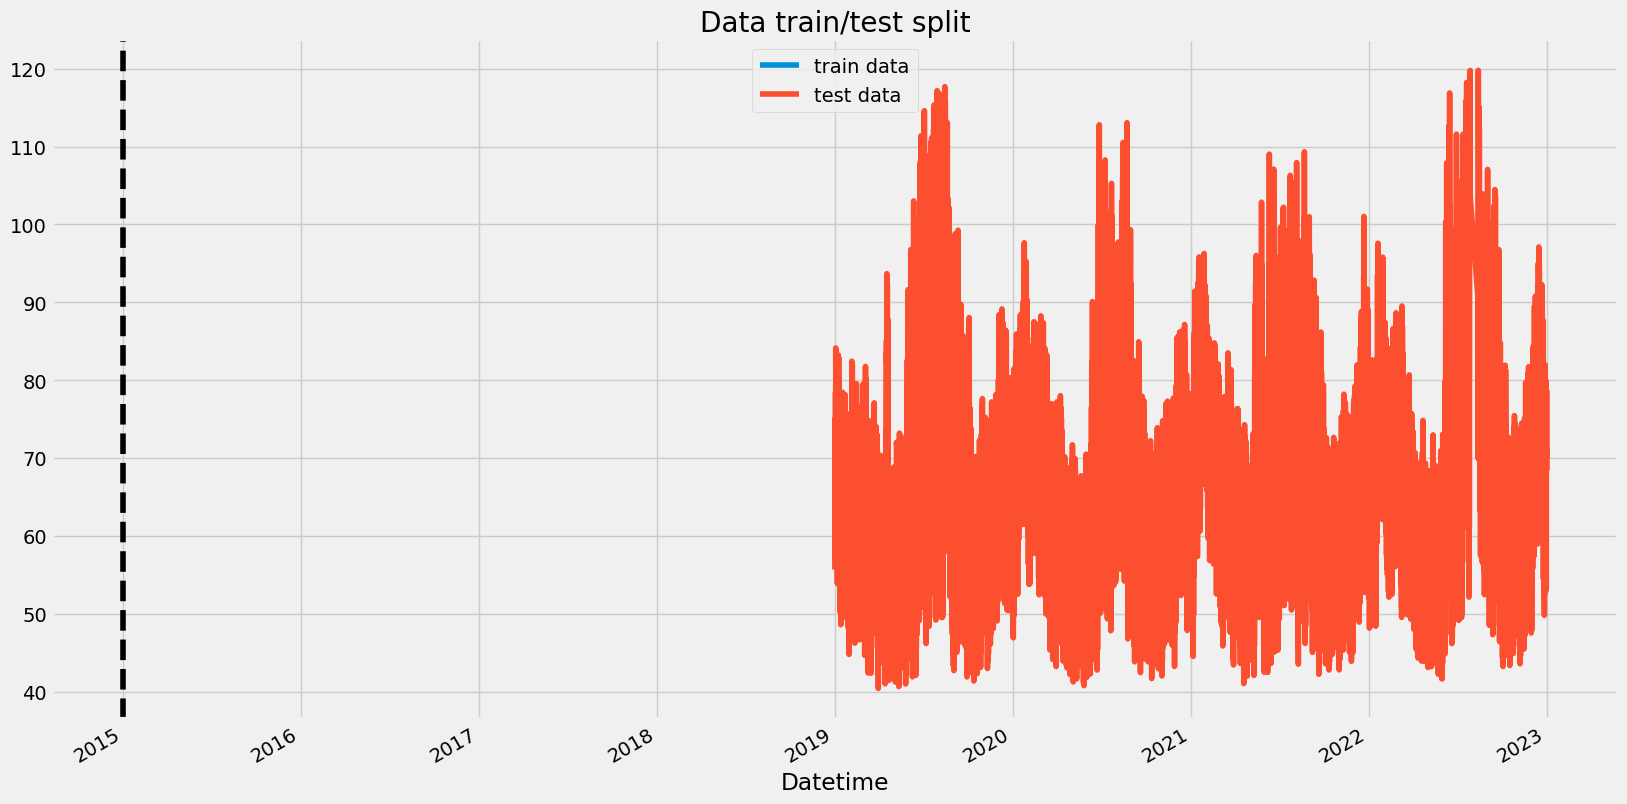

In [21]:
fig, ax = plt.subplots(figsize = (18,10))
train.plot(ax = ax)
test.plot(ax = ax)
ax.axvline('01-01-2015', ls = "--", color = "black")
plt.legend(["train data", "test data"])
plt.title("Data train/test split")
plt.show()

# run from here

In [17]:
from sklearn.model_selection import TimeSeriesSplit

In [18]:
tss = TimeSeriesSplit(n_splits= 5, gap= 24, test_size= 24*30)

In [19]:
df1 = df1.sort_index()
df1.head()

,temp
Datetime,
2019-01-01 00:00:00,55.68
2019-01-01 01:00:00,63.88
2019-01-01 02:00:00,61.51
2019-01-01 03:00:00,59.60
2019-01-01 04:00:00,58.63


In [20]:
for train_idx, val_idx in tss.split(df1):
    break
train_idx

array([    0,     1,     2, ..., 31018, 31019, 31020])

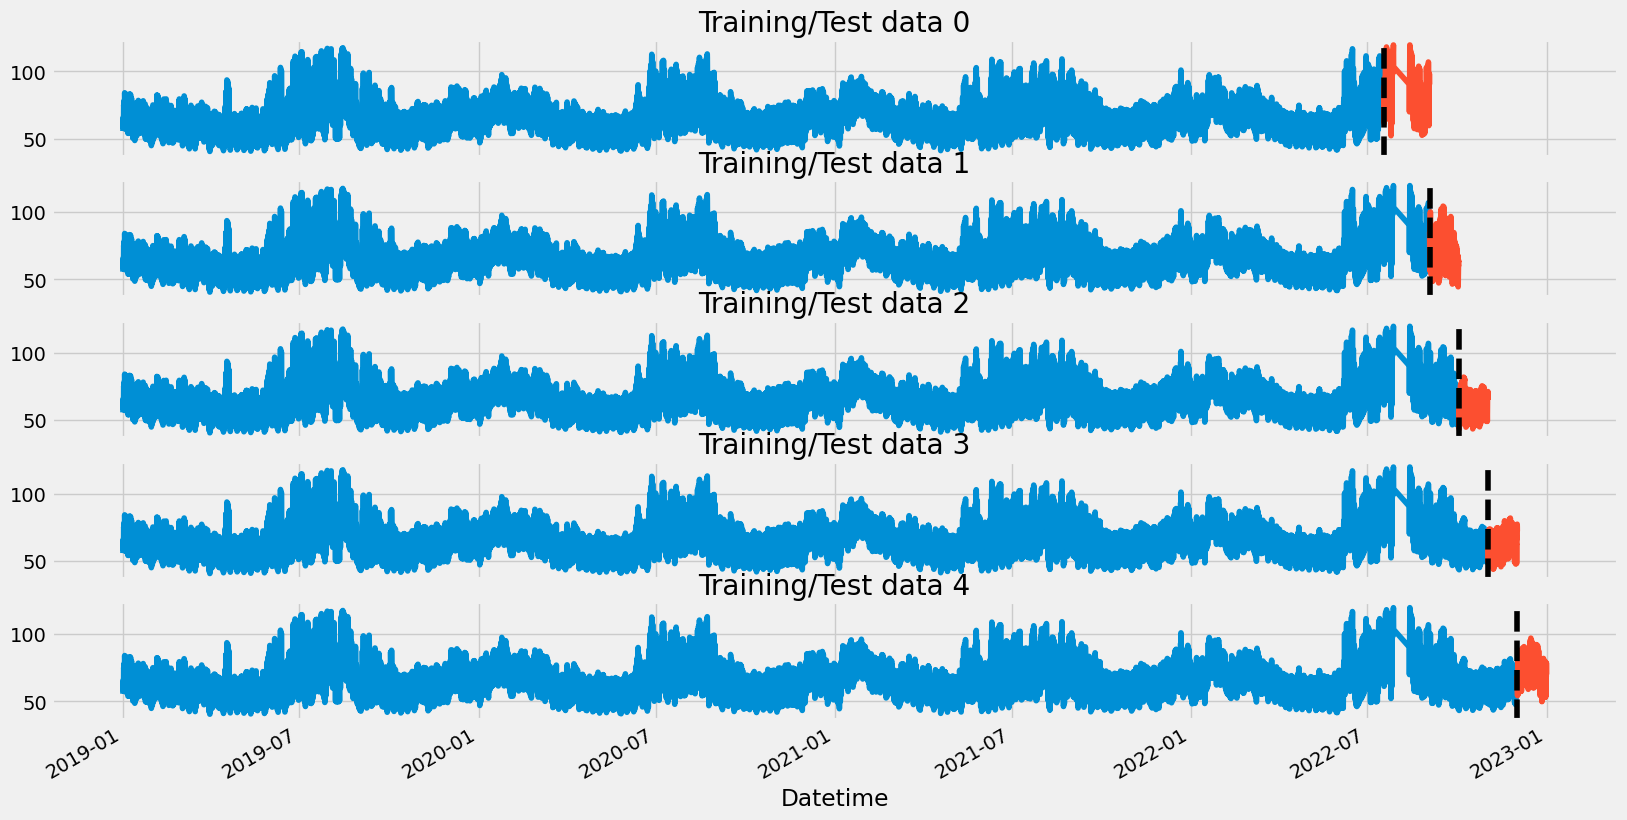

In [21]:
fig, axs = plt.subplots(5,1,figsize = (18,10), sharex= True)

fold = 0
for train_idx, val_idx in tss.split(df1):
    train = df1.iloc[train_idx]
    test = df1.iloc[val_idx]
    train["temp"].plot(ax = axs[fold], label = "Training data", title = f"Training/Test data {fold}")
    test["temp"].plot(ax = axs[fold], label = "Testing data")
    axs[fold].axvline(test.index.min(), ls = "--", color = "black")
    fold += 1
plt.show()

In [163]:
check = df1[df1.index > "07-26-2022"]
check.head(30)

,temp
Datetime,
2022-07-26 01:00:00,94.92
2022-07-26 02:00:00,67.47
2022-07-26 03:00:00,64.11
2022-07-26 04:00:00,62.18
2022-07-26 05:00:00,61.11
2022-07-26 06:00:00,61.32
2022-07-26 07:00:00,64.20
2022-07-26 08:00:00,69.19
2022-07-26 09:00:00,75.01


<Axes: title={'center': 'check'}, xlabel='Datetime'>

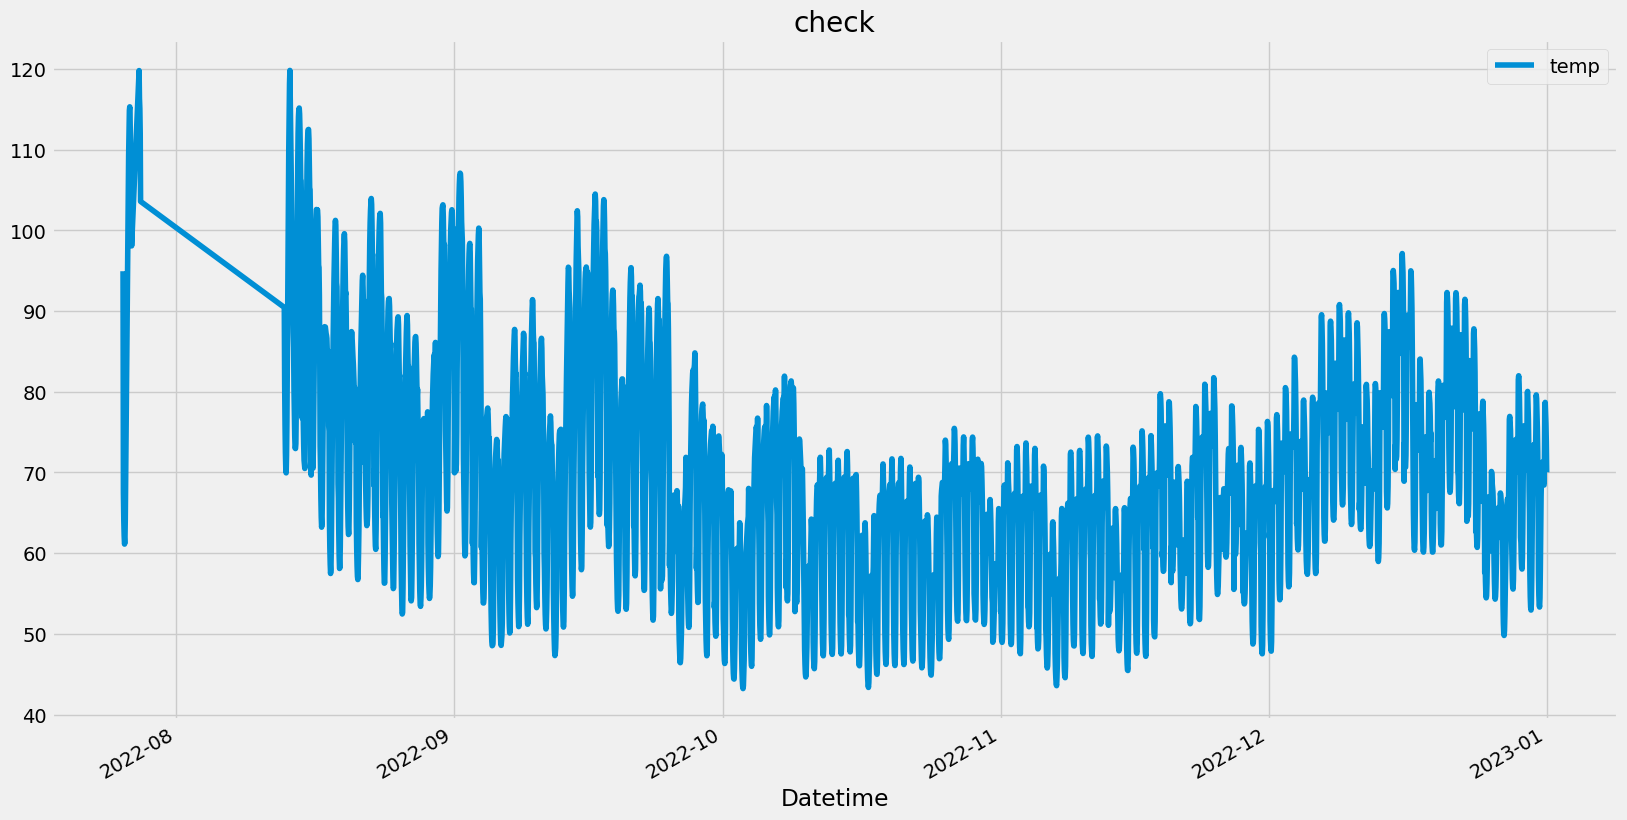

In [22]:
check = df1[df1.index > "07-26-2022"]
fig, ax = plt.subplots(figsize = (18,10))
check.plot(ax = ax, label = "check", title= "check")

In [23]:
def create_features(df):
    df = df.copy()
    df["hour"] = df.index.hour
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["quarter"] = df.index.quarter
    df["dayofweek"] = df.index.dayofweek
    df["dayofmonth"] = df.index.day
    df["dayofyear"] = df.index.dayofyear
    df["weekofyear"] = df.index.isocalendar().week
    return df

# lag features

In [24]:
def add_lags(df):
    target_map = df["temp"].to_dict()
    df["lag1"] = (df.index - pd.Timedelta('24 h')).map(target_map)
    df["lag2"] = (df.index - pd.Timedelta('48 h')).map(target_map)
    df["lag3"] = (df.index - pd.Timedelta('72 h')).map(target_map)
    df["lag4"] = (df.index - pd.Timedelta('96 h')).map(target_map)
    df["lag5"] = (df.index - pd.Timedelta('120 h')).map(target_map)
    df["lag6"] = (df.index - pd.Timedelta('144 h')).map(target_map)
    df["lag7"] = (df.index - pd.Timedelta('168 h')).map(target_map)
    df["lag8"] = (df.index - pd.Timedelta('192 h')).map(target_map)
    df["lag9"] = (df.index - pd.Timedelta('216 h')).map(target_map)
    return df

In [25]:
target_map = df["temp"].to_dict()
target_map

{Timestamp('2019-01-01 00:00:00'): 55.68,
 Timestamp('2019-12-31 01:00:00'): 52.83,
 Timestamp('2019-12-31 02:00:00'): 51.63,
 Timestamp('2019-12-31 03:00:00'): 51.24,
 Timestamp('2019-12-31 04:00:00'): 52.23,
 Timestamp('2019-12-31 05:00:00'): 55.1,
 Timestamp('2019-12-31 06:00:00'): 60.32,
 Timestamp('2019-12-31 07:00:00'): 64.53,
 Timestamp('2019-12-31 08:00:00'): 66.85,
 Timestamp('2019-12-31 09:00:00'): 68.03,
 Timestamp('2019-12-31 10:00:00'): 68.05,
 Timestamp('2019-12-31 11:00:00'): 67.06,
 Timestamp('2019-12-31 12:00:00'): 65.43,
 Timestamp('2019-12-31 13:00:00'): 63.83,
 Timestamp('2019-12-31 14:00:00'): 62.14,
 Timestamp('2019-12-31 15:00:00'): 61.16,
 Timestamp('2019-12-31 16:00:00'): 63.71,
 Timestamp('2019-12-31 17:00:00'): 71.52,
 Timestamp('2019-12-31 18:00:00'): 71.9,
 Timestamp('2019-12-31 19:00:00'): 68.94,
 Timestamp('2019-12-31 20:00:00'): 65.87,
 Timestamp('2019-12-31 21:00:00'): 62.82,
 Timestamp('2019-12-31 22:00:00'): 59.86,
 Timestamp('2019-12-31 23:00:00'): 5

In [26]:
df1 = create_features(df1)

In [27]:
df1 = add_lags(df1)

In [28]:
df1.head()

,temp,hour,month,year,quarter,dayofweek,dayofmonth,dayofyear,weekofyear,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9
Datetime,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,55.68,0,1,2019,1,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 01:00:00,63.88,1,1,2019,1,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 02:00:00,61.51,2,1,2019,1,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 03:00:00,59.60,3,1,2019,1,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 04:00:00,58.63,4,1,2019,1,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
df1.sample(5)

,temp,hour,month,year,quarter,dayofweek,dayofmonth,dayofyear,weekofyear,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9
Datetime,,,,,,,,,,,,,,,,,,
2019-05-16 20:00:00,66.21,20,5,2019,2,3,16,136,20,61.54,62.25,69.68,58.43,54.14,61.56,65.66,65.80,69.27
2019-12-20 15:00:00,67.42,15,12,2019,4,4,20,354,51,71.31,73.21,72.87,72.12,59.46,66.09,74.77,71.42,80.92
2022-08-26 20:00:00,84.83,20,8,2022,3,4,26,238,34,85.10,87.92,96.87,100.53,92.90,80.41,95.15,97.59,85.10
2019-12-25 23:00:00,64.53,23,12,2019,4,2,25,359,52,65.42,68.20,63.09,65.88,66.86,67.89,74.50,76.79,74.58
2021-04-26 01:00:00,46.57,1,4,2021,2,0,26,116,17,49.10,51.72,50.05,50.10,54.41,47.71,46.57,50.27,53.35


In [175]:
df1.iloc[600: 630,:]

,temp,hour,month,year,quarter,dayofweek,dayofmonth,dayofyear,weekofyear,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9
Datetime,,,,,,,,,,,,,,,,,,
2019-01-26 00:00:00,59.35,0,1,2019,1,5,26,26,4,55.87,56.96,59.76,60.23,59.62,62.19,63.46,60.18,60.63
2019-01-26 01:00:00,55.80,1,1,2019,1,5,26,26,4,51.75,53.05,55.94,56.42,57.07,58.80,59.71,56.72,56.70
2019-01-26 02:00:00,53.76,2,1,2019,1,5,26,26,4,49.93,51.00,53.75,54.31,55.72,56.52,57.55,54.71,54.91
2019-01-26 03:00:00,52.98,3,1,2019,1,5,26,26,4,49.44,49.90,52.89,53.80,55.29,55.43,56.62,54.18,53.79
2019-01-26 04:00:00,52.60,4,1,2019,1,5,26,26,4,49.73,49.70,52.52,53.81,55.34,55.10,56.38,53.98,54.01
2019-01-26 05:00:00,52.94,5,1,2019,1,5,26,26,4,51.13,51.05,53.63,55.51,56.85,55.15,56.60,55.37,54.90
2019-01-26 06:00:00,54.69,6,1,2019,1,5,26,26,4,55.97,55.38,57.92,60.28,60.00,56.22,57.79,59.85,59.10
2019-01-26 07:00:00,57.70,7,1,2019,1,5,26,26,4,64.90,64.22,66.58,69.12,65.37,58.49,60.26,68.28,68.03
2019-01-26 08:00:00,60.43,8,1,2019,1,5,26,26,4,70.64,69.91,72.07,73.91,69.67,60.30,63.48,73.90,73.30


In [30]:
df1.tail()

,temp,hour,month,year,quarter,dayofweek,dayofmonth,dayofyear,weekofyear,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9
Datetime,,,,,,,,,,,,,,,,,,
2022-12-31 19:00:00,78.67,19,12,2022,4,5,31,365,52,79.60,79.87,81.48,76.57,67.44,70.11,78.10,87.23,90.77
2022-12-31 20:00:00,77.38,20,12,2022,4,5,31,365,52,79.14,80.03,81.97,76.93,67.05,69.86,78.81,87.78,91.44
2022-12-31 21:00:00,76.03,21,12,2022,4,5,31,365,52,77.41,78.51,80.92,76.21,66.42,68.66,77.51,86.78,90.80
2022-12-31 22:00:00,73.77,22,12,2022,4,5,31,365,52,75.54,76.58,79.29,75.25,65.84,68.06,75.89,85.29,88.99
2022-12-31 23:00:00,70.00,23,12,2022,4,5,31,365,52,72.57,73.22,76.21,72.79,64.57,67.58,73.51,82.43,85.87


In [31]:
df1.columns

Index(['temp', 'hour', 'month', 'year', 'quarter', 'dayofweek', 'dayofmonth',
       'dayofyear', 'weekofyear', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5',
       'lag6', 'lag7', 'lag8', 'lag9'],
      dtype='object')

In [32]:
tss = TimeSeriesSplit(n_splits=5, test_size= 30*24, gap =24)
df1 = df1.sort_index()

fold = 0
preds = []
scores = []

for train_idx, val_idx in tss.split(df1):
    train = df1.iloc[train_idx]
    test = df1.iloc[val_idx]
    
    train = create_features(train)
    test = create_features(test)
    
    FEATURES = [ 'hour', 'month', 'year', 'quarter', 'dayofweek',
       'dayofmonth', 'dayofyear', 'weekofyear', 'lag1', 'lag2', 'lag3','lag4', 'lag5', 'lag6','lag7', 'lag8', 'lag9']
    TARGET = "temp"
    
    X_train = train[FEATURES]
    X_test = test[FEATURES]
    
    y_train = train[TARGET]
    y_test = test[TARGET]
    
    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           early_stopping_rounds=50,
                           objective='reg:squarederror')
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score) 

[0]	validation_0-rmse:47.71705	validation_1-rmse:60.76514
[64]	validation_0-rmse:2.58465	validation_1-rmse:10.83307
[0]	validation_0-rmse:48.02513	validation_1-rmse:50.57895
[80]	validation_0-rmse:2.40029	validation_1-rmse:6.01433
[0]	validation_0-rmse:48.10208	validation_1-rmse:43.35017
[65]	validation_0-rmse:2.64480	validation_1-rmse:2.98124
[0]	validation_0-rmse:48.00417	validation_1-rmse:44.24758
[63]	validation_0-rmse:2.57922	validation_1-rmse:3.41200
[0]	validation_0-rmse:47.92577	validation_1-rmse:51.48409
[66]	validation_0-rmse:2.60306	validation_1-rmse:4.47581


In [33]:
param_dist = {
    'max_depth': [3, 5, 8, 12, 16],
    'eta': [0.01, 0.1, 0.3],
    'gamma': [0, 0.1, 0.2, 0.3 ],
    'min_child_weight': [1,2, 3,4, 5],
    'subsample': [0.5,0.6, 0.7,0.8,0.9,1],
    'colsample_bytree': [0.5, 0.7, 1],
    "reg_alpha": [0.01, 0.1, 1, 10, 100]}

random_search = RandomizedSearchCV(estimator=reg,
                               param_distributions=param_dist,
                               scoring='neg_mean_squared_error',  # Minimize MSE
                               n_iter=10,  # Number of random parameter sets to try
                               )

# Fit the model with randomized search
random_search.fit(X_train, y_train,
                 eval_set=[(X_train, y_train), (X_test, y_test)],
                 verbose=100)


# Print the best hyperparameters found
print("Best Hyperparameters:", random_search.best_params_)

# Use the best model for prediction
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error:", rmse)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START colsample_bytree=1, eta=0.1, gamma=0.2, max_depth=5, min_child_weight=2, reg_alpha=100, subsample=0.9
[0]	validation_0-rmse:61.44396	validation_1-rmse:65.80583
[1]	validation_0-rmse:55.37086	validation_1-rmse:59.36401
[2]	validation_0-rmse:49.90886	validation_1-rmse:53.52957
[3]	validation_0-rmse:44.99243	validation_1-rmse:48.28835
[4]	validation_0-rmse:40.58163	validation_1-rmse:43.61649
[5]	validation_0-rmse:36.61449	validation_1-rmse:39.37336
[6]	validation_0-rmse:33.05232	validation_1-rmse:35.55257
[7]	validation_0-rmse:29.84966	validation_1-rmse:32.10949
[8]	validation_0-rmse:26.97915	validation_1-rmse:29.05901
[9]	validation_0-rmse:24.40818	validation_1-rmse:26.31540
[10]	validation_0-rmse:22.10175	validation_1-rmse:23.81865
[11]	validation_0-rmse:20.03021	validation_1-rmse:21.57195
[12]	validation_0-rmse:18.18168	validation_1-rmse:19.68186
[13]	validation_0-rmse:16.52169	validation_1-rmse:17.87334


[35]	validation_0-rmse:4.90605	validation_1-rmse:4.84114
[36]	validation_0-rmse:4.83689	validation_1-rmse:4.78901
[37]	validation_0-rmse:4.78088	validation_1-rmse:4.70206
[38]	validation_0-rmse:4.72510	validation_1-rmse:4.62174
[39]	validation_0-rmse:4.68046	validation_1-rmse:4.55398
[40]	validation_0-rmse:4.62857	validation_1-rmse:4.49000
[41]	validation_0-rmse:4.59456	validation_1-rmse:4.44732
[42]	validation_0-rmse:4.54134	validation_1-rmse:4.39800
[43]	validation_0-rmse:4.51109	validation_1-rmse:4.34794
[44]	validation_0-rmse:4.48367	validation_1-rmse:4.29980
[45]	validation_0-rmse:4.46010	validation_1-rmse:4.28121
[46]	validation_0-rmse:4.42257	validation_1-rmse:4.19021
[47]	validation_0-rmse:4.38163	validation_1-rmse:4.15049
[48]	validation_0-rmse:4.35038	validation_1-rmse:4.12941
[49]	validation_0-rmse:4.32502	validation_1-rmse:4.05145
[50]	validation_0-rmse:4.31175	validation_1-rmse:4.03345
[51]	validation_0-rmse:4.28367	validation_1-rmse:4.01547
[52]	validation_0-rmse:4.25768	

[74]	validation_0-rmse:4.01569	validation_1-rmse:3.84135
[75]	validation_0-rmse:4.00997	validation_1-rmse:3.84403
[76]	validation_0-rmse:3.99726	validation_1-rmse:3.84403
[77]	validation_0-rmse:3.98808	validation_1-rmse:3.84308
[78]	validation_0-rmse:3.98526	validation_1-rmse:3.84268
[79]	validation_0-rmse:3.97956	validation_1-rmse:3.84034
[80]	validation_0-rmse:3.97384	validation_1-rmse:3.84076
[81]	validation_0-rmse:3.96587	validation_1-rmse:3.84323
[82]	validation_0-rmse:3.96086	validation_1-rmse:3.84822
[83]	validation_0-rmse:3.94896	validation_1-rmse:3.84802
[84]	validation_0-rmse:3.93607	validation_1-rmse:3.84649
[85]	validation_0-rmse:3.92182	validation_1-rmse:3.83619
[86]	validation_0-rmse:3.91306	validation_1-rmse:3.83280
[87]	validation_0-rmse:3.90739	validation_1-rmse:3.82655
[88]	validation_0-rmse:3.90334	validation_1-rmse:3.82732
[89]	validation_0-rmse:3.89945	validation_1-rmse:3.82705
[90]	validation_0-rmse:3.89236	validation_1-rmse:3.82862
[91]	validation_0-rmse:3.87980	

[8]	validation_0-rmse:27.04509	validation_1-rmse:29.13875
[9]	validation_0-rmse:24.47568	validation_1-rmse:26.37040
[10]	validation_0-rmse:22.17141	validation_1-rmse:23.86380
[11]	validation_0-rmse:20.11040	validation_1-rmse:21.63944
[12]	validation_0-rmse:18.26590	validation_1-rmse:19.61063
[13]	validation_0-rmse:16.62646	validation_1-rmse:17.94662
[14]	validation_0-rmse:15.16173	validation_1-rmse:16.44179
[15]	validation_0-rmse:13.85187	validation_1-rmse:15.05232
[16]	validation_0-rmse:12.69633	validation_1-rmse:13.89169
[17]	validation_0-rmse:11.66374	validation_1-rmse:12.82446
[18]	validation_0-rmse:10.75180	validation_1-rmse:11.84605
[19]	validation_0-rmse:9.95215	validation_1-rmse:11.01974
[20]	validation_0-rmse:9.24671	validation_1-rmse:10.26166
[21]	validation_0-rmse:8.62935	validation_1-rmse:9.55411
[22]	validation_0-rmse:8.07615	validation_1-rmse:8.96394
[23]	validation_0-rmse:7.60389	validation_1-rmse:8.42373
[24]	validation_0-rmse:7.19786	validation_1-rmse:7.98746
[25]	vali

[46]	validation_0-rmse:42.89383	validation_1-rmse:46.04593
[47]	validation_0-rmse:42.47395	validation_1-rmse:45.59672
[48]	validation_0-rmse:42.05920	validation_1-rmse:45.15259
[49]	validation_0-rmse:41.65156	validation_1-rmse:44.71569
[50]	validation_0-rmse:41.24429	validation_1-rmse:44.27976
[51]	validation_0-rmse:40.84414	validation_1-rmse:43.85180
[52]	validation_0-rmse:40.44571	validation_1-rmse:43.42151
[53]	validation_0-rmse:40.05052	validation_1-rmse:42.99808
[54]	validation_0-rmse:39.65957	validation_1-rmse:42.57886
[55]	validation_0-rmse:39.27248	validation_1-rmse:42.16026
[56]	validation_0-rmse:38.89177	validation_1-rmse:41.75238
[57]	validation_0-rmse:38.51305	validation_1-rmse:41.34814
[58]	validation_0-rmse:38.13770	validation_1-rmse:40.94807
[59]	validation_0-rmse:37.76947	validation_1-rmse:40.55206
[60]	validation_0-rmse:37.40214	validation_1-rmse:40.15704
[61]	validation_0-rmse:37.03809	validation_1-rmse:39.76718
[62]	validation_0-rmse:36.68076	validation_1-rmse:39.383

[80]	validation_0-rmse:30.78316	validation_1-rmse:33.18864
[81]	validation_0-rmse:30.48672	validation_1-rmse:32.86995
[82]	validation_0-rmse:30.19360	validation_1-rmse:32.55238
[83]	validation_0-rmse:29.90527	validation_1-rmse:32.24397
[84]	validation_0-rmse:29.61806	validation_1-rmse:31.93483
[85]	validation_0-rmse:29.33689	validation_1-rmse:31.63829
[86]	validation_0-rmse:29.05786	validation_1-rmse:31.33532
[87]	validation_0-rmse:28.78149	validation_1-rmse:31.03595
[88]	validation_0-rmse:28.50559	validation_1-rmse:30.73898
[89]	validation_0-rmse:28.23215	validation_1-rmse:30.44259
[90]	validation_0-rmse:27.96268	validation_1-rmse:30.15286
[91]	validation_0-rmse:27.69739	validation_1-rmse:29.86564
[92]	validation_0-rmse:27.43302	validation_1-rmse:29.58115
[93]	validation_0-rmse:27.17465	validation_1-rmse:29.30952
[94]	validation_0-rmse:26.91894	validation_1-rmse:29.03571
[95]	validation_0-rmse:26.66474	validation_1-rmse:28.76150
[96]	validation_0-rmse:26.41062	validation_1-rmse:28.489

[10]	validation_0-rmse:61.15505	validation_1-rmse:65.54260
[11]	validation_0-rmse:60.55380	validation_1-rmse:64.90237
[12]	validation_0-rmse:59.96226	validation_1-rmse:64.27872
[13]	validation_0-rmse:59.37272	validation_1-rmse:63.65304
[14]	validation_0-rmse:58.78709	validation_1-rmse:63.02653
[15]	validation_0-rmse:58.20672	validation_1-rmse:62.40704
[16]	validation_0-rmse:57.63217	validation_1-rmse:61.79547
[17]	validation_0-rmse:57.06592	validation_1-rmse:61.18213
[18]	validation_0-rmse:56.50805	validation_1-rmse:60.58712
[19]	validation_0-rmse:55.95405	validation_1-rmse:59.99810
[20]	validation_0-rmse:55.40238	validation_1-rmse:59.40895
[21]	validation_0-rmse:54.85989	validation_1-rmse:58.82730
[22]	validation_0-rmse:54.32199	validation_1-rmse:58.24866
[23]	validation_0-rmse:53.79127	validation_1-rmse:57.68673
[24]	validation_0-rmse:53.26404	validation_1-rmse:57.12477
[25]	validation_0-rmse:52.74480	validation_1-rmse:56.57981
[26]	validation_0-rmse:52.22830	validation_1-rmse:56.026

[45]	validation_0-rmse:43.36168	validation_1-rmse:46.64141
[46]	validation_0-rmse:42.94130	validation_1-rmse:46.19207
[47]	validation_0-rmse:42.52218	validation_1-rmse:45.74266
[48]	validation_0-rmse:42.10682	validation_1-rmse:45.29711
[49]	validation_0-rmse:41.70076	validation_1-rmse:44.87624
[50]	validation_0-rmse:41.29362	validation_1-rmse:44.43949
[51]	validation_0-rmse:40.89411	validation_1-rmse:44.01190
[52]	validation_0-rmse:40.49571	validation_1-rmse:43.58317
[53]	validation_0-rmse:40.10094	validation_1-rmse:43.16079
[54]	validation_0-rmse:39.71060	validation_1-rmse:42.74255
[55]	validation_0-rmse:39.32410	validation_1-rmse:42.32853
[56]	validation_0-rmse:38.94378	validation_1-rmse:41.91972
[57]	validation_0-rmse:38.56492	validation_1-rmse:41.51339
[58]	validation_0-rmse:38.19027	validation_1-rmse:41.10994
[59]	validation_0-rmse:37.82229	validation_1-rmse:40.71550
[60]	validation_0-rmse:37.45516	validation_1-rmse:40.32067
[61]	validation_0-rmse:37.09162	validation_1-rmse:39.930

[81]	validation_0-rmse:4.85258	validation_1-rmse:3.97758
[82]	validation_0-rmse:4.84941	validation_1-rmse:3.97097
[83]	validation_0-rmse:4.84620	validation_1-rmse:3.96353
[84]	validation_0-rmse:4.84077	validation_1-rmse:3.95656
[85]	validation_0-rmse:4.83649	validation_1-rmse:3.95652
[86]	validation_0-rmse:4.83019	validation_1-rmse:3.95686
[87]	validation_0-rmse:4.81945	validation_1-rmse:3.95534
[88]	validation_0-rmse:4.81622	validation_1-rmse:3.94964
[89]	validation_0-rmse:4.81255	validation_1-rmse:3.93427
[90]	validation_0-rmse:4.81041	validation_1-rmse:3.93397
[91]	validation_0-rmse:4.80799	validation_1-rmse:3.93103
[92]	validation_0-rmse:4.80205	validation_1-rmse:3.94977
[93]	validation_0-rmse:4.79784	validation_1-rmse:3.95385
[94]	validation_0-rmse:4.77567	validation_1-rmse:3.95296
[95]	validation_0-rmse:4.76738	validation_1-rmse:3.94940
[96]	validation_0-rmse:4.76229	validation_1-rmse:3.95215
[97]	validation_0-rmse:4.75708	validation_1-rmse:3.95304
[98]	validation_0-rmse:4.75410	

[15]	validation_0-rmse:13.80691	validation_1-rmse:14.79373
[16]	validation_0-rmse:12.64943	validation_1-rmse:13.49283
[17]	validation_0-rmse:11.63061	validation_1-rmse:12.34006
[18]	validation_0-rmse:10.73176	validation_1-rmse:11.31639
[19]	validation_0-rmse:9.94334	validation_1-rmse:10.43948
[20]	validation_0-rmse:9.25250	validation_1-rmse:9.62794
[21]	validation_0-rmse:8.64998	validation_1-rmse:8.92275
[22]	validation_0-rmse:8.12742	validation_1-rmse:8.36823
[23]	validation_0-rmse:7.67248	validation_1-rmse:7.82813
[24]	validation_0-rmse:7.28548	validation_1-rmse:7.34730
[25]	validation_0-rmse:6.95160	validation_1-rmse:6.93987
[26]	validation_0-rmse:6.66754	validation_1-rmse:6.56699
[27]	validation_0-rmse:6.42780	validation_1-rmse:6.25775
[28]	validation_0-rmse:6.22247	validation_1-rmse:5.99178
[29]	validation_0-rmse:6.04698	validation_1-rmse:5.73829
[30]	validation_0-rmse:5.88473	validation_1-rmse:5.52945
[31]	validation_0-rmse:5.76025	validation_1-rmse:5.38747
[32]	validation_0-rmse

[54]	validation_0-rmse:4.90891	validation_1-rmse:4.31684
[55]	validation_0-rmse:4.88634	validation_1-rmse:4.29256
[56]	validation_0-rmse:4.87749	validation_1-rmse:4.27455
[57]	validation_0-rmse:4.87105	validation_1-rmse:4.26020
[58]	validation_0-rmse:4.86061	validation_1-rmse:4.25046
[59]	validation_0-rmse:4.83805	validation_1-rmse:4.23516
[60]	validation_0-rmse:4.83102	validation_1-rmse:4.23285
[61]	validation_0-rmse:4.82129	validation_1-rmse:4.22582
[62]	validation_0-rmse:4.81591	validation_1-rmse:4.21716
[63]	validation_0-rmse:4.79469	validation_1-rmse:4.20185
[64]	validation_0-rmse:4.78645	validation_1-rmse:4.19611
[65]	validation_0-rmse:4.78080	validation_1-rmse:4.18734
[66]	validation_0-rmse:4.76522	validation_1-rmse:4.19126
[67]	validation_0-rmse:4.75513	validation_1-rmse:4.18492
[68]	validation_0-rmse:4.73694	validation_1-rmse:4.16735
[69]	validation_0-rmse:4.73045	validation_1-rmse:4.05466
[70]	validation_0-rmse:4.72452	validation_1-rmse:4.05394
[71]	validation_0-rmse:4.71480	

[92]	validation_0-rmse:4.67704	validation_1-rmse:3.89219
[93]	validation_0-rmse:4.67167	validation_1-rmse:3.89802
[94]	validation_0-rmse:4.66832	validation_1-rmse:3.89752
[95]	validation_0-rmse:4.66600	validation_1-rmse:3.89693
[96]	validation_0-rmse:4.65529	validation_1-rmse:3.89938
[97]	validation_0-rmse:4.65325	validation_1-rmse:3.89701
[98]	validation_0-rmse:4.64866	validation_1-rmse:3.84683
[99]	validation_0-rmse:4.64419	validation_1-rmse:3.84486
[CV 5/5; 3/10] END colsample_bytree=1, eta=0.1, gamma=0.2, max_depth=3, min_child_weight=1, reg_alpha=0.1, subsample=0.9;, score=-30.183 total time=   1.3s
[CV 1/5; 4/10] START colsample_bytree=0.5, eta=0.3, gamma=0.2, max_depth=8, min_child_weight=5, reg_alpha=1, subsample=0.9
[0]	validation_0-rmse:48.07174	validation_1-rmse:51.96370
[1]	validation_0-rmse:34.04055	validation_1-rmse:37.18158
[2]	validation_0-rmse:24.32016	validation_1-rmse:27.01951
[3]	validation_0-rmse:17.43831	validation_1-rmse:19.49671
[4]	validation_0-rmse:12.87355	va

[54]	validation_0-rmse:2.66026	validation_1-rmse:4.67467
[55]	validation_0-rmse:2.65238	validation_1-rmse:4.68167
[56]	validation_0-rmse:2.64538	validation_1-rmse:4.68951
[57]	validation_0-rmse:2.64225	validation_1-rmse:4.69703
[58]	validation_0-rmse:2.63784	validation_1-rmse:4.70431
[59]	validation_0-rmse:2.63000	validation_1-rmse:4.68236
[60]	validation_0-rmse:2.62527	validation_1-rmse:4.67380
[61]	validation_0-rmse:2.61560	validation_1-rmse:4.68443
[62]	validation_0-rmse:2.61272	validation_1-rmse:4.68732
[63]	validation_0-rmse:2.59829	validation_1-rmse:4.68827
[64]	validation_0-rmse:2.59025	validation_1-rmse:4.72823
[65]	validation_0-rmse:2.58617	validation_1-rmse:4.74446
[66]	validation_0-rmse:2.57626	validation_1-rmse:4.74605
[67]	validation_0-rmse:2.57220	validation_1-rmse:4.72302
[68]	validation_0-rmse:2.55968	validation_1-rmse:4.71628
[69]	validation_0-rmse:2.55131	validation_1-rmse:4.72276
[70]	validation_0-rmse:2.54314	validation_1-rmse:4.70320
[CV 2/5; 4/10] END colsample_by

[32]	validation_0-rmse:3.30292	validation_1-rmse:5.05947
[33]	validation_0-rmse:3.28259	validation_1-rmse:5.06417
[34]	validation_0-rmse:3.26698	validation_1-rmse:5.05771
[35]	validation_0-rmse:3.25261	validation_1-rmse:5.05464
[36]	validation_0-rmse:3.23993	validation_1-rmse:5.06832
[37]	validation_0-rmse:3.22564	validation_1-rmse:5.07665
[38]	validation_0-rmse:3.20458	validation_1-rmse:5.11110
[39]	validation_0-rmse:3.19064	validation_1-rmse:5.11775
[40]	validation_0-rmse:3.17507	validation_1-rmse:5.12542
[41]	validation_0-rmse:3.16980	validation_1-rmse:5.12097
[42]	validation_0-rmse:3.16047	validation_1-rmse:5.12196
[43]	validation_0-rmse:3.14986	validation_1-rmse:5.15281
[44]	validation_0-rmse:3.13916	validation_1-rmse:5.14904
[45]	validation_0-rmse:3.12625	validation_1-rmse:5.15282
[46]	validation_0-rmse:3.11037	validation_1-rmse:5.13916
[47]	validation_0-rmse:3.10763	validation_1-rmse:5.17617
[48]	validation_0-rmse:3.09183	validation_1-rmse:5.17623
[49]	validation_0-rmse:3.08461	

[17]	validation_0-rmse:57.03204	validation_1-rmse:61.17874
[18]	validation_0-rmse:56.47061	validation_1-rmse:60.58810
[19]	validation_0-rmse:55.91436	validation_1-rmse:59.99070
[20]	validation_0-rmse:55.36139	validation_1-rmse:59.39975
[21]	validation_0-rmse:54.81720	validation_1-rmse:58.82220
[22]	validation_0-rmse:54.27735	validation_1-rmse:58.24533
[23]	validation_0-rmse:53.74411	validation_1-rmse:57.68045
[24]	validation_0-rmse:53.21629	validation_1-rmse:57.12160
[25]	validation_0-rmse:52.69393	validation_1-rmse:56.56911
[26]	validation_0-rmse:52.17632	validation_1-rmse:56.02452
[27]	validation_0-rmse:51.66093	validation_1-rmse:55.47378
[28]	validation_0-rmse:51.15349	validation_1-rmse:54.93201
[29]	validation_0-rmse:50.65268	validation_1-rmse:54.40649
[30]	validation_0-rmse:50.15195	validation_1-rmse:53.87016
[31]	validation_0-rmse:49.65663	validation_1-rmse:53.34134
[32]	validation_0-rmse:49.16685	validation_1-rmse:52.81457
[33]	validation_0-rmse:48.68433	validation_1-rmse:52.294

[51]	validation_0-rmse:40.78220	validation_1-rmse:44.06360
[52]	validation_0-rmse:40.38239	validation_1-rmse:43.63966
[53]	validation_0-rmse:39.98633	validation_1-rmse:43.21494
[54]	validation_0-rmse:39.59433	validation_1-rmse:42.79991
[55]	validation_0-rmse:39.20598	validation_1-rmse:42.38317
[56]	validation_0-rmse:38.82422	validation_1-rmse:41.97968
[57]	validation_0-rmse:38.44439	validation_1-rmse:41.57210
[58]	validation_0-rmse:38.06813	validation_1-rmse:41.16843
[59]	validation_0-rmse:37.69866	validation_1-rmse:40.78396
[60]	validation_0-rmse:37.33001	validation_1-rmse:40.38732
[61]	validation_0-rmse:36.96520	validation_1-rmse:39.99576
[62]	validation_0-rmse:36.60705	validation_1-rmse:39.61450
[63]	validation_0-rmse:36.24925	validation_1-rmse:39.22974
[64]	validation_0-rmse:35.89861	validation_1-rmse:38.86453
[65]	validation_0-rmse:35.54858	validation_1-rmse:38.49076
[66]	validation_0-rmse:35.20422	validation_1-rmse:38.12928
[67]	validation_0-rmse:34.86076	validation_1-rmse:37.760

[86]	validation_0-rmse:28.97780	validation_1-rmse:31.43792
[87]	validation_0-rmse:28.69982	validation_1-rmse:31.15349
[88]	validation_0-rmse:28.42313	validation_1-rmse:30.85963
[89]	validation_0-rmse:28.14876	validation_1-rmse:30.56395
[90]	validation_0-rmse:27.87774	validation_1-rmse:30.27404
[91]	validation_0-rmse:27.61148	validation_1-rmse:29.98980
[92]	validation_0-rmse:27.34592	validation_1-rmse:29.71126
[93]	validation_0-rmse:27.08521	validation_1-rmse:29.43423
[94]	validation_0-rmse:26.82780	validation_1-rmse:29.15815
[95]	validation_0-rmse:26.57241	validation_1-rmse:28.88398
[96]	validation_0-rmse:26.31692	validation_1-rmse:28.60891
[97]	validation_0-rmse:26.06506	validation_1-rmse:28.33936
[98]	validation_0-rmse:25.81711	validation_1-rmse:28.08064
[99]	validation_0-rmse:25.56960	validation_1-rmse:27.81755
[CV 3/5; 5/10] END colsample_bytree=0.5, eta=0.01, gamma=0.2, max_depth=5, min_child_weight=1, reg_alpha=0.01, subsample=0.9;, score=-640.500 total time=   1.6s
[CV 4/5; 5/10

[15]	validation_0-rmse:58.20355	validation_1-rmse:62.49092
[16]	validation_0-rmse:57.62878	validation_1-rmse:61.87555
[17]	validation_0-rmse:57.06232	validation_1-rmse:61.27788
[18]	validation_0-rmse:56.50352	validation_1-rmse:60.70016
[19]	validation_0-rmse:55.94992	validation_1-rmse:60.12546
[20]	validation_0-rmse:55.39773	validation_1-rmse:59.53378
[21]	validation_0-rmse:54.85529	validation_1-rmse:58.95941
[22]	validation_0-rmse:54.31761	validation_1-rmse:58.39231
[23]	validation_0-rmse:53.78653	validation_1-rmse:57.82757
[24]	validation_0-rmse:53.25931	validation_1-rmse:57.27867
[25]	validation_0-rmse:52.73892	validation_1-rmse:56.74494
[26]	validation_0-rmse:52.22237	validation_1-rmse:56.20911
[27]	validation_0-rmse:51.70761	validation_1-rmse:55.65952
[28]	validation_0-rmse:51.20247	validation_1-rmse:55.13186
[29]	validation_0-rmse:50.70389	validation_1-rmse:54.61282
[30]	validation_0-rmse:50.20442	validation_1-rmse:54.07877
[31]	validation_0-rmse:49.71011	validation_1-rmse:53.549

[50]	validation_0-rmse:41.14858	validation_1-rmse:44.18962
[51]	validation_0-rmse:40.74571	validation_1-rmse:43.76075
[52]	validation_0-rmse:40.34677	validation_1-rmse:43.33394
[53]	validation_0-rmse:39.95187	validation_1-rmse:42.91116
[54]	validation_0-rmse:39.56119	validation_1-rmse:42.49621
[55]	validation_0-rmse:39.17463	validation_1-rmse:42.08406
[56]	validation_0-rmse:38.79178	validation_1-rmse:41.67586
[57]	validation_0-rmse:38.41382	validation_1-rmse:41.26817
[58]	validation_0-rmse:38.03915	validation_1-rmse:40.87272
[59]	validation_0-rmse:37.66801	validation_1-rmse:40.47652
[60]	validation_0-rmse:37.30054	validation_1-rmse:40.08167
[61]	validation_0-rmse:36.93700	validation_1-rmse:39.69395
[62]	validation_0-rmse:36.57678	validation_1-rmse:39.30855
[63]	validation_0-rmse:36.22012	validation_1-rmse:38.92433
[64]	validation_0-rmse:35.86738	validation_1-rmse:38.54568
[65]	validation_0-rmse:35.51838	validation_1-rmse:38.17050
[66]	validation_0-rmse:35.17256	validation_1-rmse:37.799

[84]	validation_0-rmse:29.51496	validation_1-rmse:31.80004
[85]	validation_0-rmse:29.23077	validation_1-rmse:31.49839
[86]	validation_0-rmse:28.94975	validation_1-rmse:31.19745
[87]	validation_0-rmse:28.67131	validation_1-rmse:30.89830
[88]	validation_0-rmse:28.39574	validation_1-rmse:30.60221
[89]	validation_0-rmse:28.12296	validation_1-rmse:30.31125
[90]	validation_0-rmse:27.85340	validation_1-rmse:30.02399
[91]	validation_0-rmse:27.58602	validation_1-rmse:29.73734
[92]	validation_0-rmse:27.32206	validation_1-rmse:29.45654
[93]	validation_0-rmse:27.06027	validation_1-rmse:29.17499
[94]	validation_0-rmse:26.80158	validation_1-rmse:28.90124
[95]	validation_0-rmse:26.54547	validation_1-rmse:28.62886
[96]	validation_0-rmse:26.29207	validation_1-rmse:28.35943
[97]	validation_0-rmse:26.04118	validation_1-rmse:28.09315
[98]	validation_0-rmse:25.79255	validation_1-rmse:27.82557
[99]	validation_0-rmse:25.54666	validation_1-rmse:27.56054
[CV 2/5; 6/10] END colsample_bytree=1, eta=0.01, gamma=0

[14]	validation_0-rmse:58.75021	validation_1-rmse:62.99768
[15]	validation_0-rmse:58.16975	validation_1-rmse:62.38315
[16]	validation_0-rmse:57.59546	validation_1-rmse:61.77437
[17]	validation_0-rmse:57.02680	validation_1-rmse:61.16864
[18]	validation_0-rmse:56.46365	validation_1-rmse:60.56990
[19]	validation_0-rmse:55.90636	validation_1-rmse:59.97890
[20]	validation_0-rmse:55.35489	validation_1-rmse:59.38886
[21]	validation_0-rmse:54.80900	validation_1-rmse:58.80843
[22]	validation_0-rmse:54.26845	validation_1-rmse:58.23301
[23]	validation_0-rmse:53.73354	validation_1-rmse:57.66454
[24]	validation_0-rmse:53.20370	validation_1-rmse:57.09973
[25]	validation_0-rmse:52.67930	validation_1-rmse:56.54148
[26]	validation_0-rmse:52.16028	validation_1-rmse:55.98940
[27]	validation_0-rmse:51.64688	validation_1-rmse:55.44440
[28]	validation_0-rmse:51.13788	validation_1-rmse:54.89997
[29]	validation_0-rmse:50.63400	validation_1-rmse:54.36187
[30]	validation_0-rmse:50.13534	validation_1-rmse:53.827

[49]	validation_0-rmse:41.59072	validation_1-rmse:44.68787
[50]	validation_0-rmse:41.18436	validation_1-rmse:44.25564
[51]	validation_0-rmse:40.78232	validation_1-rmse:43.82527
[52]	validation_0-rmse:40.38463	validation_1-rmse:43.40466
[53]	validation_0-rmse:39.99060	validation_1-rmse:42.98401
[54]	validation_0-rmse:39.60043	validation_1-rmse:42.56696
[55]	validation_0-rmse:39.21414	validation_1-rmse:42.14861
[56]	validation_0-rmse:38.83189	validation_1-rmse:41.74209
[57]	validation_0-rmse:38.45361	validation_1-rmse:41.33901
[58]	validation_0-rmse:38.07889	validation_1-rmse:40.93863
[59]	validation_0-rmse:37.70837	validation_1-rmse:40.54312
[60]	validation_0-rmse:37.34178	validation_1-rmse:40.15338
[61]	validation_0-rmse:36.97917	validation_1-rmse:39.76873
[62]	validation_0-rmse:36.61960	validation_1-rmse:39.38193
[63]	validation_0-rmse:36.26354	validation_1-rmse:38.99981
[64]	validation_0-rmse:35.91167	validation_1-rmse:38.62707
[65]	validation_0-rmse:35.56295	validation_1-rmse:38.255

[83]	validation_0-rmse:29.77710	validation_1-rmse:32.21106
[84]	validation_0-rmse:29.48725	validation_1-rmse:31.90095
[85]	validation_0-rmse:29.20382	validation_1-rmse:31.60536
[86]	validation_0-rmse:28.92326	validation_1-rmse:31.30981
[87]	validation_0-rmse:28.64511	validation_1-rmse:31.02671
[88]	validation_0-rmse:28.36737	validation_1-rmse:30.72883
[89]	validation_0-rmse:28.09305	validation_1-rmse:30.43319
[90]	validation_0-rmse:27.82184	validation_1-rmse:30.14398
[91]	validation_0-rmse:27.55316	validation_1-rmse:29.85139
[92]	validation_0-rmse:27.28752	validation_1-rmse:29.56986
[93]	validation_0-rmse:27.02459	validation_1-rmse:29.28975
[94]	validation_0-rmse:26.76662	validation_1-rmse:29.01509
[95]	validation_0-rmse:26.50927	validation_1-rmse:28.74030
[96]	validation_0-rmse:26.25315	validation_1-rmse:28.46839
[97]	validation_0-rmse:26.00112	validation_1-rmse:28.19873
[98]	validation_0-rmse:25.75256	validation_1-rmse:27.94203
[99]	validation_0-rmse:25.50485	validation_1-rmse:27.677

[12]	validation_0-rmse:59.93629	validation_1-rmse:64.34791
[13]	validation_0-rmse:59.34621	validation_1-rmse:63.72666
[14]	validation_0-rmse:58.75933	validation_1-rmse:63.09834
[15]	validation_0-rmse:58.17788	validation_1-rmse:62.47644
[16]	validation_0-rmse:57.60208	validation_1-rmse:61.86833
[17]	validation_0-rmse:57.03381	validation_1-rmse:61.26912
[18]	validation_0-rmse:56.47258	validation_1-rmse:60.68632
[19]	validation_0-rmse:55.91728	validation_1-rmse:60.10032
[20]	validation_0-rmse:55.36433	validation_1-rmse:59.50695
[21]	validation_0-rmse:54.81932	validation_1-rmse:58.93936
[22]	validation_0-rmse:54.28046	validation_1-rmse:58.36498
[23]	validation_0-rmse:53.74761	validation_1-rmse:57.82307
[24]	validation_0-rmse:53.21910	validation_1-rmse:57.27862
[25]	validation_0-rmse:52.69627	validation_1-rmse:56.73669
[26]	validation_0-rmse:52.17835	validation_1-rmse:56.19010
[27]	validation_0-rmse:51.66307	validation_1-rmse:55.64151
[28]	validation_0-rmse:51.15576	validation_1-rmse:55.110

[47]	validation_0-rmse:42.41086	validation_1-rmse:45.81625
[48]	validation_0-rmse:41.99457	validation_1-rmse:45.37677
[49]	validation_0-rmse:41.58491	validation_1-rmse:44.93533
[50]	validation_0-rmse:41.17668	validation_1-rmse:44.50487
[51]	validation_0-rmse:40.77570	validation_1-rmse:44.09485
[52]	validation_0-rmse:40.37574	validation_1-rmse:43.66553
[53]	validation_0-rmse:39.97942	validation_1-rmse:43.24068
[54]	validation_0-rmse:39.58739	validation_1-rmse:42.82053
[55]	validation_0-rmse:39.19917	validation_1-rmse:42.40448
[56]	validation_0-rmse:38.81738	validation_1-rmse:41.99305
[57]	validation_0-rmse:38.43693	validation_1-rmse:41.59015
[58]	validation_0-rmse:38.06077	validation_1-rmse:41.18708
[59]	validation_0-rmse:37.68874	validation_1-rmse:40.78895
[60]	validation_0-rmse:37.32042	validation_1-rmse:40.39395
[61]	validation_0-rmse:36.95548	validation_1-rmse:40.00281
[62]	validation_0-rmse:36.59412	validation_1-rmse:39.61412
[63]	validation_0-rmse:36.23593	validation_1-rmse:39.232

[81]	validation_0-rmse:30.45290	validation_1-rmse:33.03964
[82]	validation_0-rmse:30.15971	validation_1-rmse:32.72456
[83]	validation_0-rmse:29.87068	validation_1-rmse:32.42007
[84]	validation_0-rmse:29.58249	validation_1-rmse:32.11228
[85]	validation_0-rmse:29.29979	validation_1-rmse:31.81228
[86]	validation_0-rmse:29.01928	validation_1-rmse:31.51155
[87]	validation_0-rmse:28.74197	validation_1-rmse:31.22971
[88]	validation_0-rmse:28.46471	validation_1-rmse:30.93093
[89]	validation_0-rmse:28.19074	validation_1-rmse:30.63305
[90]	validation_0-rmse:27.92035	validation_1-rmse:30.34264
[91]	validation_0-rmse:27.65146	validation_1-rmse:30.05550
[92]	validation_0-rmse:27.38567	validation_1-rmse:29.76906
[93]	validation_0-rmse:27.12322	validation_1-rmse:29.48943
[94]	validation_0-rmse:26.86561	validation_1-rmse:29.21681
[95]	validation_0-rmse:26.60889	validation_1-rmse:28.94028
[96]	validation_0-rmse:26.35398	validation_1-rmse:28.66522
[97]	validation_0-rmse:26.10173	validation_1-rmse:28.398

[11]	validation_0-rmse:60.51649	validation_1-rmse:64.88269
[12]	validation_0-rmse:59.91760	validation_1-rmse:64.24595
[13]	validation_0-rmse:59.32454	validation_1-rmse:63.61499
[14]	validation_0-rmse:58.73800	validation_1-rmse:62.99176
[15]	validation_0-rmse:58.15702	validation_1-rmse:62.37760
[16]	validation_0-rmse:57.58224	validation_1-rmse:61.76887
[17]	validation_0-rmse:57.01298	validation_1-rmse:61.16332
[18]	validation_0-rmse:56.44997	validation_1-rmse:60.56440
[19]	validation_0-rmse:55.89240	validation_1-rmse:59.97177
[20]	validation_0-rmse:55.34024	validation_1-rmse:59.38446
[21]	validation_0-rmse:54.79351	validation_1-rmse:58.80321
[22]	validation_0-rmse:54.25202	validation_1-rmse:58.22754
[23]	validation_0-rmse:53.71672	validation_1-rmse:57.65682
[24]	validation_0-rmse:53.18671	validation_1-rmse:57.09472
[25]	validation_0-rmse:52.66171	validation_1-rmse:56.53959
[26]	validation_0-rmse:52.14225	validation_1-rmse:55.98810
[27]	validation_0-rmse:51.62791	validation_1-rmse:55.442

[46]	validation_0-rmse:42.79816	validation_1-rmse:46.00764
[47]	validation_0-rmse:42.37843	validation_1-rmse:45.56165
[48]	validation_0-rmse:41.96348	validation_1-rmse:45.12117
[49]	validation_0-rmse:41.55256	validation_1-rmse:44.68218
[50]	validation_0-rmse:41.14540	validation_1-rmse:44.24377
[51]	validation_0-rmse:40.74251	validation_1-rmse:43.81491
[52]	validation_0-rmse:40.34405	validation_1-rmse:43.39304
[53]	validation_0-rmse:39.94906	validation_1-rmse:42.96933
[54]	validation_0-rmse:39.55826	validation_1-rmse:42.55361
[55]	validation_0-rmse:39.17160	validation_1-rmse:42.14310
[56]	validation_0-rmse:38.78846	validation_1-rmse:41.73278
[57]	validation_0-rmse:38.40967	validation_1-rmse:41.32832
[58]	validation_0-rmse:38.03491	validation_1-rmse:40.92923
[59]	validation_0-rmse:37.66341	validation_1-rmse:40.53016
[60]	validation_0-rmse:37.29587	validation_1-rmse:40.13782
[61]	validation_0-rmse:36.93210	validation_1-rmse:39.75262
[62]	validation_0-rmse:36.57188	validation_1-rmse:39.366

[80]	validation_0-rmse:30.71124	validation_1-rmse:33.17216
[81]	validation_0-rmse:30.41541	validation_1-rmse:32.85306
[82]	validation_0-rmse:30.12273	validation_1-rmse:32.54088
[83]	validation_0-rmse:29.83244	validation_1-rmse:32.22711
[84]	validation_0-rmse:29.54576	validation_1-rmse:31.92052
[85]	validation_0-rmse:29.26171	validation_1-rmse:31.61793
[86]	validation_0-rmse:28.98058	validation_1-rmse:31.32430
[87]	validation_0-rmse:28.70220	validation_1-rmse:31.02559
[88]	validation_0-rmse:28.42693	validation_1-rmse:30.73361
[89]	validation_0-rmse:28.15456	validation_1-rmse:30.44294
[90]	validation_0-rmse:27.88509	validation_1-rmse:30.15518
[91]	validation_0-rmse:27.61783	validation_1-rmse:29.86784
[92]	validation_0-rmse:27.35382	validation_1-rmse:29.58653
[93]	validation_0-rmse:27.09237	validation_1-rmse:29.30557
[94]	validation_0-rmse:26.83405	validation_1-rmse:29.03763
[95]	validation_0-rmse:26.57810	validation_1-rmse:28.77192
[96]	validation_0-rmse:26.32474	validation_1-rmse:28.499

[10]	validation_0-rmse:22.12720	validation_1-rmse:23.74003
[11]	validation_0-rmse:20.06563	validation_1-rmse:21.53335
[12]	validation_0-rmse:18.22737	validation_1-rmse:19.50034
[13]	validation_0-rmse:16.57619	validation_1-rmse:17.68437
[14]	validation_0-rmse:15.10854	validation_1-rmse:16.08318
[15]	validation_0-rmse:13.79377	validation_1-rmse:14.63619
[16]	validation_0-rmse:12.62922	validation_1-rmse:13.46436
[17]	validation_0-rmse:11.59694	validation_1-rmse:12.29958
[18]	validation_0-rmse:10.68526	validation_1-rmse:11.34544
[19]	validation_0-rmse:9.87077	validation_1-rmse:10.44076
[20]	validation_0-rmse:9.16647	validation_1-rmse:9.71406
[21]	validation_0-rmse:8.55445	validation_1-rmse:9.07108
[22]	validation_0-rmse:8.01731	validation_1-rmse:8.50526
[23]	validation_0-rmse:7.55170	validation_1-rmse:7.97478
[24]	validation_0-rmse:7.14824	validation_1-rmse:7.47357
[25]	validation_0-rmse:6.79118	validation_1-rmse:7.01960
[26]	validation_0-rmse:6.49975	validation_1-rmse:6.70306
[27]	validat

[48]	validation_0-rmse:4.38731	validation_1-rmse:4.27239
[49]	validation_0-rmse:4.36909	validation_1-rmse:4.26435
[50]	validation_0-rmse:4.34682	validation_1-rmse:4.17760
[51]	validation_0-rmse:4.33350	validation_1-rmse:4.16917
[52]	validation_0-rmse:4.31822	validation_1-rmse:4.16669
[53]	validation_0-rmse:4.30429	validation_1-rmse:4.10890
[54]	validation_0-rmse:4.28231	validation_1-rmse:4.05222
[55]	validation_0-rmse:4.26939	validation_1-rmse:4.03929
[56]	validation_0-rmse:4.25796	validation_1-rmse:4.03826
[57]	validation_0-rmse:4.23207	validation_1-rmse:4.02562
[58]	validation_0-rmse:4.21354	validation_1-rmse:4.00621
[59]	validation_0-rmse:4.20253	validation_1-rmse:4.00775
[60]	validation_0-rmse:4.18428	validation_1-rmse:3.98356
[61]	validation_0-rmse:4.17525	validation_1-rmse:3.99564
[62]	validation_0-rmse:4.16323	validation_1-rmse:3.99864
[63]	validation_0-rmse:4.15119	validation_1-rmse:3.95575
[64]	validation_0-rmse:4.14408	validation_1-rmse:3.95349
[65]	validation_0-rmse:4.13510	

[86]	validation_0-rmse:3.95876	validation_1-rmse:4.16817
[87]	validation_0-rmse:3.95470	validation_1-rmse:4.16876
[88]	validation_0-rmse:3.95031	validation_1-rmse:4.17134
[89]	validation_0-rmse:3.94333	validation_1-rmse:4.15440
[90]	validation_0-rmse:3.93771	validation_1-rmse:4.14984
[91]	validation_0-rmse:3.93443	validation_1-rmse:4.15298
[92]	validation_0-rmse:3.92809	validation_1-rmse:4.15170
[93]	validation_0-rmse:3.92123	validation_1-rmse:4.15651
[94]	validation_0-rmse:3.91452	validation_1-rmse:4.16011
[95]	validation_0-rmse:3.90353	validation_1-rmse:4.15499
[96]	validation_0-rmse:3.89150	validation_1-rmse:4.15817
[97]	validation_0-rmse:3.88616	validation_1-rmse:4.16445
[98]	validation_0-rmse:3.87969	validation_1-rmse:4.16544
[99]	validation_0-rmse:3.87502	validation_1-rmse:4.16343
[CV 3/5; 9/10] END colsample_bytree=1, eta=0.1, gamma=0.1, max_depth=5, min_child_weight=5, reg_alpha=100, subsample=0.7;, score=-18.309 total time=   2.3s
[CV 4/5; 9/10] START colsample_bytree=1, eta=0

[18]	validation_0-rmse:10.78375	validation_1-rmse:11.67526
[19]	validation_0-rmse:9.98321	validation_1-rmse:10.79438
[20]	validation_0-rmse:9.27273	validation_1-rmse:10.03780
[21]	validation_0-rmse:8.66287	validation_1-rmse:9.43837
[22]	validation_0-rmse:8.10759	validation_1-rmse:8.79573
[23]	validation_0-rmse:7.63114	validation_1-rmse:8.29423
[24]	validation_0-rmse:7.21337	validation_1-rmse:7.79247
[25]	validation_0-rmse:6.85836	validation_1-rmse:7.39505
[26]	validation_0-rmse:6.55480	validation_1-rmse:7.02623
[27]	validation_0-rmse:6.29458	validation_1-rmse:6.70399
[28]	validation_0-rmse:6.05837	validation_1-rmse:6.40413
[29]	validation_0-rmse:5.85700	validation_1-rmse:6.17200
[30]	validation_0-rmse:5.69619	validation_1-rmse:5.97333
[31]	validation_0-rmse:5.55451	validation_1-rmse:5.79460
[32]	validation_0-rmse:5.42201	validation_1-rmse:5.62078
[33]	validation_0-rmse:5.31896	validation_1-rmse:5.47768
[34]	validation_0-rmse:5.21699	validation_1-rmse:5.33323
[35]	validation_0-rmse:5.14

[56]	validation_0-rmse:5.03146	validation_1-rmse:4.20576
[57]	validation_0-rmse:5.02777	validation_1-rmse:4.19817
[58]	validation_0-rmse:5.02074	validation_1-rmse:4.19785
[59]	validation_0-rmse:5.01388	validation_1-rmse:4.19496
[60]	validation_0-rmse:5.00928	validation_1-rmse:4.18981
[61]	validation_0-rmse:5.00294	validation_1-rmse:4.11519
[62]	validation_0-rmse:4.99830	validation_1-rmse:4.11362
[63]	validation_0-rmse:4.99410	validation_1-rmse:4.11124
[64]	validation_0-rmse:4.99031	validation_1-rmse:4.10546
[65]	validation_0-rmse:4.98389	validation_1-rmse:4.09108
[66]	validation_0-rmse:4.96864	validation_1-rmse:4.09025
[67]	validation_0-rmse:4.96513	validation_1-rmse:4.08808
[68]	validation_0-rmse:4.95997	validation_1-rmse:4.04924
[69]	validation_0-rmse:4.95647	validation_1-rmse:4.04775
[70]	validation_0-rmse:4.94881	validation_1-rmse:4.04357
[71]	validation_0-rmse:4.94380	validation_1-rmse:4.04278
[72]	validation_0-rmse:4.93922	validation_1-rmse:4.04436
[73]	validation_0-rmse:4.93499	

[94]	validation_0-rmse:4.55355	validation_1-rmse:3.93090
[95]	validation_0-rmse:4.54761	validation_1-rmse:3.93116
[96]	validation_0-rmse:4.54072	validation_1-rmse:3.94424
[97]	validation_0-rmse:4.52783	validation_1-rmse:3.94031
[98]	validation_0-rmse:4.52062	validation_1-rmse:3.94373
[99]	validation_0-rmse:4.51535	validation_1-rmse:3.93865
[CV 2/5; 10/10] END colsample_bytree=1, eta=0.1, gamma=0.2, max_depth=3, min_child_weight=1, reg_alpha=0.1, subsample=1;, score=-17.472 total time=   1.9s
[CV 3/5; 10/10] START colsample_bytree=1, eta=0.1, gamma=0.2, max_depth=3, min_child_weight=1, reg_alpha=0.1, subsample=1
[0]	validation_0-rmse:61.43994	validation_1-rmse:65.83029
[1]	validation_0-rmse:55.36564	validation_1-rmse:59.40674
[2]	validation_0-rmse:49.90319	validation_1-rmse:53.61128
[3]	validation_0-rmse:44.99230	validation_1-rmse:48.39519
[4]	validation_0-rmse:40.57819	validation_1-rmse:43.70370
[5]	validation_0-rmse:36.61445	validation_1-rmse:39.45065
[6]	validation_0-rmse:33.05272	va

[27]	validation_0-rmse:6.46231	validation_1-rmse:6.44594
[28]	validation_0-rmse:6.25669	validation_1-rmse:6.16623
[29]	validation_0-rmse:6.07938	validation_1-rmse:5.90551
[30]	validation_0-rmse:5.93017	validation_1-rmse:5.71617
[31]	validation_0-rmse:5.80403	validation_1-rmse:5.52194
[32]	validation_0-rmse:5.69886	validation_1-rmse:5.37386
[33]	validation_0-rmse:5.60916	validation_1-rmse:5.24492
[34]	validation_0-rmse:5.53087	validation_1-rmse:5.13373
[35]	validation_0-rmse:5.46164	validation_1-rmse:5.04489
[36]	validation_0-rmse:5.40291	validation_1-rmse:4.97720
[37]	validation_0-rmse:5.35239	validation_1-rmse:4.90876
[38]	validation_0-rmse:5.31306	validation_1-rmse:4.84942
[39]	validation_0-rmse:5.27562	validation_1-rmse:4.78632
[40]	validation_0-rmse:5.23605	validation_1-rmse:4.72739
[41]	validation_0-rmse:5.20175	validation_1-rmse:4.67957
[42]	validation_0-rmse:5.17750	validation_1-rmse:4.64438
[43]	validation_0-rmse:5.15745	validation_1-rmse:4.61631
[44]	validation_0-rmse:5.13510	

[66]	validation_0-rmse:4.87827	validation_1-rmse:4.10992
[67]	validation_0-rmse:4.85950	validation_1-rmse:4.09044
[68]	validation_0-rmse:4.85412	validation_1-rmse:4.08453
[69]	validation_0-rmse:4.84933	validation_1-rmse:4.05787
[70]	validation_0-rmse:4.83653	validation_1-rmse:4.05411
[71]	validation_0-rmse:4.83250	validation_1-rmse:4.04841
[72]	validation_0-rmse:4.82847	validation_1-rmse:4.04798
[73]	validation_0-rmse:4.82010	validation_1-rmse:4.03961
[74]	validation_0-rmse:4.81142	validation_1-rmse:4.03944
[75]	validation_0-rmse:4.80581	validation_1-rmse:4.03753
[76]	validation_0-rmse:4.80039	validation_1-rmse:4.03524
[77]	validation_0-rmse:4.79459	validation_1-rmse:4.02504
[78]	validation_0-rmse:4.79055	validation_1-rmse:4.01909
[79]	validation_0-rmse:4.78424	validation_1-rmse:4.01540
[80]	validation_0-rmse:4.77831	validation_1-rmse:4.01538
[81]	validation_0-rmse:4.77233	validation_1-rmse:4.01362
[82]	validation_0-rmse:4.76842	validation_1-rmse:3.99349
[83]	validation_0-rmse:4.75905	

In [ ]:
# Best Hyperparameters: {'subsample': 0.9, 'reg_alpha': 100, 'min_child_weight': 2, 'max_depth': 5, 'gamma': 0.2, 
#                        'eta': 0.1, 'colsample_bytree': 1}
# Root Mean Squared Error: 4.010167383681601

In [34]:
print(preds)

[array([ 88.13764 ,  88.13764 ,  87.20174 ,  85.08225 ,  79.43088 ,
        74.93392 ,  70.15029 ,  66.32596 ,  63.75946 ,  61.46346 ,
        61.542316,  62.27355 ,  62.305832,  64.55297 ,  66.74835 ,
        75.74065 ,  81.724915,  89.37423 ,  89.70839 ,  88.7827  ,
        88.7827  ,  92.653625,  92.653625,  94.09638 ,  89.78194 ,
        87.924164,  87.05329 ,  84.33521 ,  82.35903 ,  84.06941 ,
        72.71295 ,  68.62964 ,  64.887566,  62.20948 ,  62.216396,
        62.868374,  66.655426,  74.82296 ,  80.16514 ,  88.00551 ,
        88.85467 ,  92.91995 ,  96.13835 ,  96.46772 ,  97.014336,
        98.403946, 101.24213 , 101.300735,  95.287994,  94.83171 ,
        93.474365,  89.92898 ,  85.99149 ,  85.34144 ,  72.945625,
        68.85969 ,  67.5661  ,  65.74558 ,  68.101006,  69.38092 ,
        74.13808 ,  85.1653  ,  87.923225,  94.53903 ,  97.60571 ,
       101.37899 , 100.26299 , 101.6526  , 101.6526  , 101.6526  ,
       101.6526  , 100.36895 ,  98.80173 , 100.92034 ,  97.93

In [42]:
print(scores) # score = rmse

[10.544051150621375, 5.819618939173513, 2.7668823779318883, 3.3297714574717885, 3.8800631281756015]


In [43]:
print(f'Score across folds {np.mean(scores):0.4f}') # score = rmse
print(f'Fold scores:{scores}')

Score across folds 5.2681
Fold scores:[10.544051150621375, 5.819618939173513, 2.7668823779318883, 3.3297714574717885, 3.8800631281756015]


In [44]:
from sklearn.metrics import mean_absolute_percentage_error
print(mean_absolute_percentage_error(y_test, y_pred))

0.043262980873421425


In [45]:
y_test

Datetime
2022-12-02 00:00:00    66.23
2022-12-02 01:00:00    68.91
2022-12-02 02:00:00    56.74
2022-12-02 03:00:00    54.91
2022-12-02 04:00:00    54.21
                       ...  
2022-12-31 19:00:00    78.67
2022-12-31 20:00:00    77.38
2022-12-31 21:00:00    76.03
2022-12-31 22:00:00    73.77
2022-12-31 23:00:00    70.00
Name: temp, Length: 720, dtype: float64

In [46]:
y_pred

array([63.621662, 63.052685, 55.567574, 51.825512, 50.55568 , 50.175682,
       51.195824, 56.36081 , 62.36401 , 65.894035, 68.47596 , 70.44229 ,
       70.85412 , 70.006424, 69.397255, 68.16211 , 67.14903 , 66.681206,
       69.2349  , 77.09865 , 77.48988 , 77.00771 , 75.21796 , 72.983574,
       66.19353 , 65.57432 , 58.48679 , 56.718506, 55.936974, 56.70762 ,
       58.19021 , 62.475815, 69.88831 , 72.836914, 72.687256, 72.629715,
       71.34275 , 70.69702 , 70.40638 , 69.69753 , 70.05583 , 71.07048 ,
       73.72869 , 78.571686, 78.571686, 77.84558 , 75.968956, 73.1769  ,
       68.07035 , 61.48544 , 59.56002 , 57.343334, 56.592   , 56.41729 ,
       55.66841 , 60.472115, 64.11368 , 68.09346 , 68.78139 , 69.09087 ,
       69.67709 , 69.39099 , 69.336395, 68.101166, 67.744026, 69.02914 ,
       72.462326, 77.76136 , 76.79656 , 76.471214, 74.95247 , 71.656   ,
       70.05322 , 61.031124, 60.426254, 58.7124  , 58.092793, 57.239483,
       58.056034, 58.934437, 60.96378 , 63.720997, 

In [40]:
df1 = create_features(df1)

FEATURES = [ 'hour', 'month', 'year', 'quarter', 'dayofweek',
       'dayofmonth', 'dayofyear', 'weekofyear', 'lag1', 'lag2', 'lag3','lag4', 'lag5', 'lag6','lag7', 'lag8', 'lag9']
TARGET = "temp"

X_all = df1[FEATURES]
y_all = df1[TARGET]

  
reg = xgb.XGBRegressor(base_score = 0.5, booster = 'gbtree',
                      early_stopping_rounds = 50,
                      objective='reg:squarederror',
                      param_distributions= random_search.best_params_
                      )
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:47.99467


C:\Users\Preetam\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [15:52:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "param_distributions" } are not used.

  warnings.warn(smsg, UserWarning)


[99]	validation_0-rmse:2.22691


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None,
             param_distributions={'colsample_bytree': 1, 'eta': 0.1,
                                  'gamma': 0.2, 'max_depth': 5,
                                  'min_child_weight': 2, 'reg_alpha': 100,
                                  'subsample': 0.9}, ...)

In [41]:
random_search.best_params_

{'subsample': 0.9,
 'reg_alpha': 100,
 'min_child_weight': 2,
 'max_depth': 5,
 'gamma': 0.2,
 'eta': 0.1,
 'colsample_bytree': 1}

In [47]:
df1.index.max()

Timestamp('2022-12-31 23:00:00')

In [48]:
future = pd.date_range('2023-01-01','2023-01-31', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
future_df

,isFuture
2023-01-01 00:00:00,True
2023-01-01 01:00:00,True
2023-01-01 02:00:00,True
2023-01-01 03:00:00,True
2023-01-01 04:00:00,True
...,...
2023-01-30 20:00:00,True
2023-01-30 21:00:00,True
2023-01-30 22:00:00,True
2023-01-30 23:00:00,True


In [49]:
df1.head()

,temp,hour,month,year,quarter,dayofweek,dayofmonth,dayofyear,weekofyear,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9
Datetime,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,55.68,0,1,2019,1,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 01:00:00,63.88,1,1,2019,1,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 02:00:00,61.51,2,1,2019,1,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 03:00:00,59.60,3,1,2019,1,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 04:00:00,58.63,4,1,2019,1,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
df1['isFuture'] = False
df_and_future = pd.concat([df1, future_df])
print(df_and_future.shape)
df_and_future.head()

(35366, 19)


,temp,hour,month,year,quarter,dayofweek,dayofmonth,dayofyear,weekofyear,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,isFuture
2019-01-01 00:00:00,55.68,0.0,1.0,2019.0,1.0,1.0,1.0,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2019-01-01 01:00:00,63.88,1.0,1.0,2019.0,1.0,1.0,1.0,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2019-01-01 02:00:00,61.51,2.0,1.0,2019.0,1.0,1.0,1.0,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2019-01-01 03:00:00,59.60,3.0,1.0,2019.0,1.0,1.0,1.0,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2019-01-01 04:00:00,58.63,4.0,1.0,2019.0,1.0,1.0,1.0,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [51]:
df_and_future.tail()

,temp,hour,month,year,quarter,dayofweek,dayofmonth,dayofyear,weekofyear,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,isFuture
2023-01-30 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2023-01-30 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2023-01-30 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2023-01-30 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2023-01-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [52]:
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)
df_and_future

,temp,hour,month,year,quarter,dayofweek,dayofmonth,dayofyear,weekofyear,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,isFuture
2019-01-01 00:00:00,55.68,0,1,2019,1,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2019-01-01 01:00:00,63.88,1,1,2019,1,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2019-01-01 02:00:00,61.51,2,1,2019,1,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2019-01-01 03:00:00,59.60,3,1,2019,1,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2019-01-01 04:00:00,58.63,4,1,2019,1,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-30 20:00:00,NaN,20,1,2023,1,0,30,30,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2023-01-30 21:00:00,NaN,21,1,2023,1,0,30,30,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2023-01-30 22:00:00,NaN,22,1,2023,1,0,30,30,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2023-01-30 23:00:00,NaN,23,1,2023,1,0,30,30,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [53]:
df_and_future.tail()

,temp,hour,month,year,quarter,dayofweek,dayofmonth,dayofyear,weekofyear,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,isFuture
2023-01-30 20:00:00,NaN,20,1,2023,1,0,30,30,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2023-01-30 21:00:00,NaN,21,1,2023,1,0,30,30,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2023-01-30 22:00:00,NaN,22,1,2023,1,0,30,30,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2023-01-30 23:00:00,NaN,23,1,2023,1,0,30,30,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2023-01-31 00:00:00,NaN,0,1,2023,1,1,31,31,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [54]:
df_and_future.index.max()

Timestamp('2023-01-31 00:00:00')

In [55]:
future_w_features = df_and_future.query('isFuture').copy()
future_w_features

,temp,hour,month,year,quarter,dayofweek,dayofmonth,dayofyear,weekofyear,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,isFuture
2023-01-01 00:00:00,NaN,0,1,2023,1,6,1,1,52,67.62,67.81,71.21,68.27,61.75,65.91,69.36,76.53,79.92,True
2023-01-01 01:00:00,NaN,1,1,2023,1,6,1,1,52,57.45,64.95,61.94,61.96,65.65,63.18,57.59,62.65,63.94,True
2023-01-01 02:00:00,NaN,2,1,2023,1,6,1,1,52,54.80,57.36,61.27,59.26,53.69,59.12,59.22,65.04,68.12,True
2023-01-01 03:00:00,NaN,3,1,2023,1,6,1,1,52,53.59,54.63,59.14,56.80,51.28,56.48,56.50,62.33,65.73,True
2023-01-01 04:00:00,NaN,4,1,2023,1,6,1,1,52,53.31,53.30,58.16,55.73,50.11,54.93,55.00,60.98,64.62,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-30 20:00:00,NaN,20,1,2023,1,0,30,30,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2023-01-30 21:00:00,NaN,21,1,2023,1,0,30,30,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2023-01-30 22:00:00,NaN,22,1,2023,1,0,30,30,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2023-01-30 23:00:00,NaN,23,1,2023,1,0,30,30,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [56]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

In [57]:
future_w_features

,temp,hour,month,year,quarter,dayofweek,dayofmonth,dayofyear,weekofyear,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,isFuture,pred
2023-01-01 00:00:00,NaN,0,1,2023,1,6,1,1,52,67.62,67.81,71.21,68.27,61.75,65.91,69.36,76.53,79.92,True,66.903381
2023-01-01 01:00:00,NaN,1,1,2023,1,6,1,1,52,57.45,64.95,61.94,61.96,65.65,63.18,57.59,62.65,63.94,True,54.280697
2023-01-01 02:00:00,NaN,2,1,2023,1,6,1,1,52,54.80,57.36,61.27,59.26,53.69,59.12,59.22,65.04,68.12,True,56.043072
2023-01-01 03:00:00,NaN,3,1,2023,1,6,1,1,52,53.59,54.63,59.14,56.80,51.28,56.48,56.50,62.33,65.73,True,52.360535
2023-01-01 04:00:00,NaN,4,1,2023,1,6,1,1,52,53.31,53.30,58.16,55.73,50.11,54.93,55.00,60.98,64.62,True,50.728718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-30 20:00:00,NaN,20,1,2023,1,0,30,30,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,84.511757
2023-01-30 21:00:00,NaN,21,1,2023,1,0,30,30,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,84.511757
2023-01-30 22:00:00,NaN,22,1,2023,1,0,30,30,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,83.897072
2023-01-30 23:00:00,NaN,23,1,2023,1,0,30,30,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,83.499382


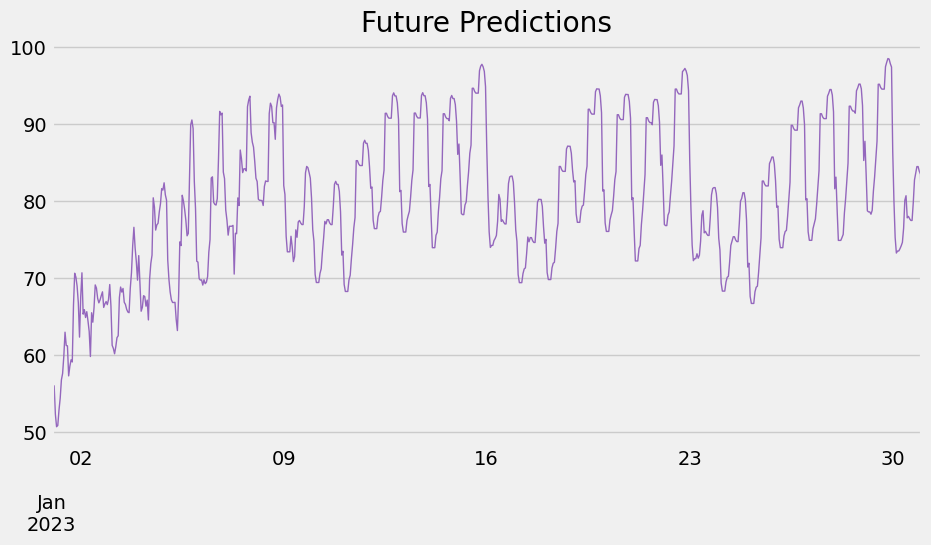

In [58]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

# save the model

In [59]:
reg.save_model('model.json')

In [60]:
!ls -lh

'ls' is not recognized as an internal or external command,
operable program or batch file.


<Axes: title={'center': 'Future Predictions'}>

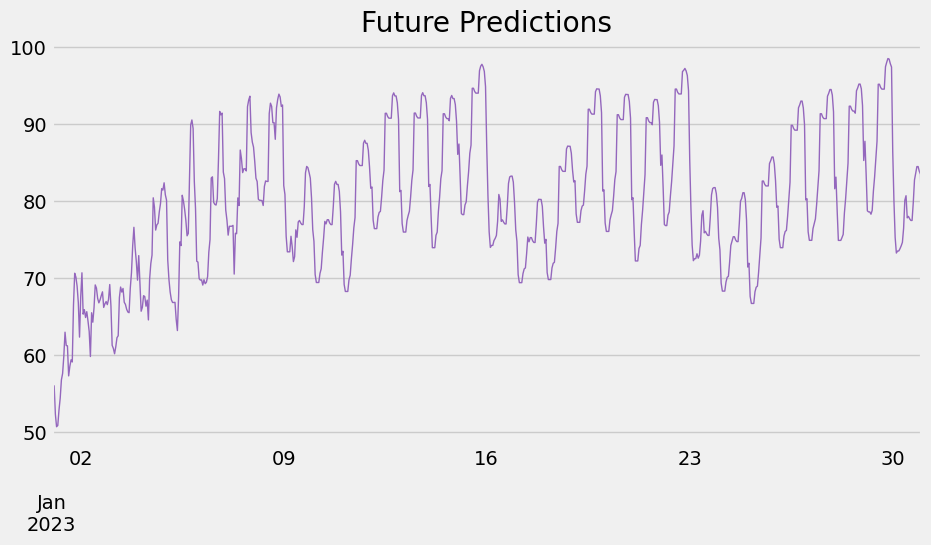

In [61]:
reg_new = xgb.XGBRegressor()
reg_new.load_model('model.json')
future_w_features['pred'] = reg_new.predict(future_w_features[FEATURES])
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1, lw=1,
                               title='Future Predictions')